In [32]:
import os
import calendar
import climpy as cp
import pandas as pd
import xarray as xr
import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import STL
from scipy import stats
import matplotlib as mpl
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator
#sns.set_style('darkgrid')


# Índice de bloqueios

In [2]:
def posix(datasets, bloq = 'continuo', freq='D'):
    
    '''
    Função que gera um dataset dos índices de vorticidade e divergência (índice calculado separadamente para cada variável 'vort' e 'div'). 
    
    Os índices são calculados em função da ocorrência de 3+ dias consecutivos de vorticidade/divergência positivas.

    Portanto, se há três dias consecutivos de vorticidade positiva, será computado 1 dia de "bloqueio" na variável 'vort'.
    
    Analogamente, se há três dias consecutivos de divergência positiva, será computado 1 dia de "bloqueio" na variável 'div'.
    
    OBS.: Aqui o termo "bloqueio" corresponde a 3+ dias consecutivos de 'vort' ou 'div' positivas e não a 1 dia de ocorrência de bloqueio atmosférico, diferente do que ocorre na função 'blockix' (conferir docstring).

    Call signature.: 
     
        posix(datasets, bloq='continuo', freq='D')
        
    Parameters
    ----------
    
    datasets: list of <xarray.Dataset>
    
        Lista de datasets de divergência e vorticidade, sem importar a ordem em que estes estão dispostos na lista.
        
        Ex: datasets = [vort_850, div_850] <--> [div_850, vort_850] --> ordem não importa
    
    bloq: str, {'continuo', 'total'}
    
        Modo de visualização dos índices de divergência e vorticidade. 
        
        Se ** bloq == 'continuo' **, a partir do 3° dia de divergência/vorticidade positiva será computado 1 dia de "bloqueio" e, se o dia seguinte também apresentar tal condição, será computado 2 dias de "bloqueio" (este seria o 2° dia consecutivo de "bloqueio"). 
        
        Se ** bloq == 'total' **, serão computados apenas os totais de dias de "bloqueio" (coerente apenas se a análise for mensal <-> * freq == 'M' *)
    
        Ex: (continuo)
        
            Se o dia 1979-01-03 for o 3° dia de div/vort positiva, será computado 1 dia de "bloqueio" para a variável correspondente ('div' ou 'vort').
            
            Se o dia 1979-01-04 for o 4° dia de div/vort positiva, será computado 2 dias de "bloqueio" (2° dia consecutivo de "bloqueio") para a variável correspondente ('div' ou 'vort').
    
        Ex: (total)
        
            Se no mês de janeiro de 1979 tiveram 8 dias de "bloqueio", será computado apenas esse total, e não os dias de "bloqueio" dispostos continuamente.
    
    freq: str, {'D', 'M'}
    
        Frequência temporal da série de dados. 
        
            Se * freq == 'D' *, a análise será diária.
        
            Se * freq == 'M' *, a análise será mensal.
        
        Ex: Dimensão 'time' do dataset 
        
            Se * freq == 'D' * --> 1979-01-01, 1979-01-02, 1979-01-03 ... dia a dia
                                     
            Se * freq == 'M' * --> 1979-01-01, 1979-02-01, 1979-03-01 ... mês a mês
                                     
    Returns
    -------
    obj : <xarray.Dataset>
    
        Dataset dos índices de divergência e vorticidade. 
        
        Valores das variáveis do dataset ('vort' e 'div') são os dias de "bloqueio" computados para cada dia/mês do intervalo temporal (dimensão 'time').
        
        OBS.:  Valores NaN correspondem às datas em que divergência/vorticidade não são positivas.

    '''
    da = [] 
    level = []
    variables = []
    
    # Mesmo recebendo um único dataset, este será tratado como lista para facilitar o loop de persistência
    if type(datasets) != list:
        datasets = [datasets]
        
    # Número ilimitado de datasets --> permite análise de vort/div em diferentes levels --> cria uma variável para cada level (var_name) no mesmo dataset (!!)
    for ds in datasets:
        
        start = pd.to_datetime(ds.dataset.time.values[0])
        end = pd.to_datetime(ds.dataset.time.values[-1])
#         latitudes = [ds.dataset.lat.values[0], ds.dataset.lat.values[-1]]   --> NÃO PRECISA, POIS PUXA LAT E LON DIRETO DOS ATRIBUTOS !!
#         longitudes = [ds.dataset.lon.values[0], ds.dataset.lon.values[-1]]  --> NÃO PRECISA, POIS PUXA LAT E LON DIRETO DOS ATRIBUTOS !!
        
        # nome da variável do dataset original
        ext_name = ds.dataset.to_array().isel(variable=0)
        var = str(ext_name['variable'].values)
        
        # calculando média regional
        med = ds.aave()
        # criando coordinate 'time' como valores dtype = datetime64[ns], pois 'aave' está retornando valores de dimensão 'time' com dtype = int64 (!!)
        med = med.dataset.assign_coords({"time": ds.dataset.time.values}) 
        # pegando somente valores positivos para cálculo de persistência
        dropped = med.where(med[var]>0, drop=True)
        
        # contadores e dict 'bloqueios' que retornarão o dataset de dias de persistência
        # Contador 'count' contabiliza APENAS dias CONSECUTIVOS
        # Contador 'bloqueios' contabiliza dias de persistência --> 3+ dias consecutivos de vort/div positivo
        count = 0
        bloqueio = 0 
        bloqueios = {}

        for ix, dia in enumerate(pd.to_datetime(dropped.time.values)):
            
            # Primeiro time.day --> contador sempre começando --> count += 1 --> como count é inicialmente = 0 --> count = 1
            # Bloqueio continua zerado porque, para ser contabilizado como 'bloqueio' (persistência) tem que ser no mínimo 3 dias consecutivos de div/vort positivo (!!!!)
            # Como é o primeiro dia de análise, impossível ser contabilizado como 'bloqueio' (persistência) (!!!!!!!)
            if ix == 0:
                count += 1
                bloqueio = 0
                bloqueios.update({dia: bloqueio})
                
            else:
                # Checando se o próximo valor de time.day com valores de div/vort positivos é um dia consecutivo ( EX: 1979-01-01, 1979-01-02 --> dias consecutivos )
                if (dia == pd.to_datetime(dropped.time.values[ix-1]) + datetime.timedelta(days = 1)) and (dia.day != 1):
                    count += 1
                    if count >= 3:
                        # Se o time.day é 3+ dia consecutivo de vort/div positivo ---> contabiliza 1 dia de persistência ---> bloqueios +=1
                        bloqueio += 1
                        
                    if bloq == 'total':
                        # Só coerente se FREQ=="M" ou FREQ="S"
                        # Como queremos o valor total de bloqueios no mês/season --> computaremos apenas o total de dias de 'bloqueio', não os dias consecutivos
                        # Serão encontrados valores != 0 apenas nos últimos dias das sequência de dias de persistência 
                        # EX: se VORT > 0 em 1979-01-01, 1979-01-02, 1979-01-03, 1979-01-04 --> 4 dias consecutivos de vort positiva --> 2 dias de 'bloqueio' (persistência)
                        
                        # Se bloq == "total" --> será computado valor 2 no dia 1979-01-04 --> foram 2 dias de 'bloqueio' no total, finalizando a sequência de dias de 'bloqueio' em 1979-01-04
                        # valor 2 indica que houve uma sequência de dias no mês/season que contabilizou 2 dias de 'bloqueio' --> sequência de 4 dias consecutivos de vort/div positivo
                        bloqueios.update({dia - datetime.timedelta(days = 1): 0})
                        bloqueios.update({dia: bloqueio})
                    else:
                        # Se bloq == "continuo" --> será computado valor 1 no dia 1979-01-03 e valor 2 no dia 1979-01-04 --> valores indicam a sequência de dias de 'bloqueio'
                        # valor 1 indica o primeiro dia de 'bloqueio' <--> terceiro dia consecutivo de vort/div positivo (!!!)
                        # valor 2 indica o segundo dia de 'bloqueio' <--> quarto dia consecutivo de vort/div positivo (!!!)
                        bloqueios.update({dia: bloqueio})
                else:
                    # Próximo valor de time.day com valores de div/vort positivos NÃO é um dia consecutivo (EX: 1979-01-01, 1979-02-12 --> dias não consecutivos) --> 'count' REINICIA (=1)
                    # 'Count' reinicia e 'bloqueio' zera porque o time.day NÃO é um dia consecutivo ao time.day anterior, logo não pode contabilizar 'count' nem 'bloqueio'
                    count = 1
                    bloqueio = 0
                    bloqueios.update({dia: bloqueio})
                    
        # valores de level que serão atributos
        # caso há combinação de variáveis em diferentes levels, todos os valores de level estarão dispostos
        level.append(ds.dataset.attrs['level'])
        # nome da variável do dataset a ser gerado --> var + valor de level
        var_name = var + " " + str(ds.dataset.attrs['level'])
        variables.append(var_name)
        # criando um DataArray a partir do dict 'bloqueios'
        da.append(xr.DataArray(list(bloqueios.values()), coords=[list(bloqueios.keys())], dims=['time'], name=var_name))
        
    # dando merge nos objetos DataArray e convertendo para Dataset
    new_ds = xr.merge(da)
    new_ds = new_ds.reindex({"time": pd.date_range(start=start, end=end, freq="D")})
    # preservando os atributos do dataset original
    new_ds.attrs = ds.dataset.attrs
    new_ds.attrs['vars by level'] = [[var for var in variables][i] for i in range(len(variables))]

    
    if freq == 'D':
#         ds.attrs['lat'] = str(latitudes[0]) + " : " + str(latitudes[1])  --> NÃO PRECISA, POIS PUXA LAT E LON DIRETO DOS ATRIBUTOS !!
#         ds.attrs['lon'] = str(longitudes[0]) + " : " + str(longitudes[1])  --> NÃO PRECISA, POIS PUXA LAT E LON DIRETO DOS ATRIBUTOS !!
        new_ds.attrs['level'] = level
        return new_ds
    
    elif freq == 'M' and bloq == 'total':
        new_ds = new_ds.resample(time='MS').sum()
        # preservando os atributos do dataset original --> após o resample, atributos são perdidos
        new_ds.attrs = ds.dataset.attrs
        new_ds.attrs['level'] = level
        return new_ds
    
    elif freq == 'S' and bloq == 'total':
        new_ds = new_ds.resample(time='QS-DEC').sum()
        # preservando os atributos do dataset original --> após o resample, atributos são perdidos
        new_ds.attrs = ds.dataset.attrs
        new_ds.attrs['level'] = level
        return new_ds

In [3]:
def blockix(ds, bloq='continuo', freq='D'):
    
    '''
    Função que gera um dataset do índice de bloqueios (um único índice em função dos índices de 'vort' e 'div' gerados na função 'posix'). 
    
    O índice de bloqueios é calculado em função da ocorrência de 3+ dias consecutivos de vorticidade *E* divergência positivas.
    
    Portanto, se há 3 dias consecutivos de vorticidade *E* divergência positivas, será computado 1 dia de bloqueio.
    
    OBS.: Aqui, o termo bloqueio se refere à ocorrência de bloqueio atmosférico, diferente do sentido do termo "bloqueio" encontrado na função 'posix' (conferir sua docstring)

    Call signature.:
    
        blockix(ds, bloq='continuo', freq='D')
        
    Parameters
    ----------
    
    ds: list of <xarray.Dataset>
    
        Lista de datasets de divergência e vorticidade, sem importar a ordem em que estes estão dispostos na lista.
        
        Ex: datasets = [vort_850, div_850] <--> [div_850, vort_850] --> ordem não importa
    
    bloq: str, {'continuo', 'total'}
    
        Modo de visualização do índice de bloqueios. 
        
        Se ** bloq == 'continuo' **, a partir do 3° dia de divergência *E* vorticidade positiva será computado 1 dia de bloqueio e, se o dia seguinte também apresentar tal condição, será computado 2 dias de bloqueio (este seria o 2° dia consecutivo de bloqueio). 
        
        Se ** bloq == 'total' **, serão computados apenas os totais de dias de bloqueio (coerente apenas se análise for mensal <-> ** freq == 'M' **
    
        Ex (contínuo): 
            
            Se o dia 1979-01-03 for o 3° dia consecutivo de 'div' E 'vort' positiva, será computado 1 dia de bloqueio
            
            Se o dia 1979-01-04 for o 4° dia consecutivo de 'div' E 'vort' positiva, será computado 2 dias de bloqueio (2° dia consecutivo de bloqueio)
    
        Ex (total): 
        
            Se no mês de janeiro de 1979 tiveram 8 dias de bloqueio, será computado apenas esse total, e não os dias de bloqueio dispostos continuamente.
    
    freq: str, {'D', 'M'}
    
        Frequência temporal da série de dados.
        
            Se * freq == 'D' *, a análise será diária.
        
            Se * freq == 'M' *, a análise será mensal.
        
        Ex: Dimensão 'time' do dataset 
        
            se * freq == 'D' * --> 1979-01-01, 1979-01-02, 1979-01-03 ... dia a dia
            se * freq == 'M' * --> 1979-01-01, 1979-02-01, 1979-03-01 ... mês a mês
                                     
    Returns
    -------
    obj : <xarray.Dataset>
        
        Dataset do índice de bloqueios. 
        
        Valores da variável do dataset ('índice de bloqueios') serão os dias de bloqueio computados para cada dia/mês do intervalo temporal (dimensão 'time').
    
    '''
    
    bloqueios = {}
    positivos = posix(ds, bloq="continuo", freq="D")
    datas = positivos.to_array().dropna("time", "any")
    count = 0
    
    for ix, dia in enumerate(pd.to_datetime(datas.time.values)):
        
        if ix == 0:
            if (all(datas.sel(time=dia).values) != 0) == True:
#             if datas.div.sel(time=dia) != 0 and datas.vort.sel(time=dia) != 0:
                count += 1
            else: 
                count = 0
            bloqueios.update({dia: count})

        if (dia == pd.to_datetime(datas.time.values[ix-1]) + datetime.timedelta(days = 1)) and (dia.day != 1):
            
#             if datas.div.sel(time=dia) != 0 and datas.vort.sel(time=dia) != 0:
            if (all(datas.sel(time=dia).values) != 0) == True:
                
                count += 1
                
                if bloq == 'total':
                    bloqueios.update({dia - datetime.timedelta(days = 1): 0})
                    bloqueios.update({dia: count})

                elif bloq == 'continuo':
    #                 bloqueios.update({dia - datetime.timedelta(days = 1): count-1})
                    bloqueios.update({dia: count})

            else:
                count = 0
                bloqueios.update({dia: count})    

        else:
#             if datas.div.sel(time=dia) != 0 and datas.vort.sel(time=dia) != 0:
            if (all(datas.sel(time=dia).values) != 0) == True:
                count = 1
            else:
                count = 0
            bloqueios.update({dia: count})

    indice = xr.DataArray(list(bloqueios.values()), coords=[list(bloqueios.keys())], dims=['time'], name='bloqueios')
    indice = indice.reindex({"time": pd.date_range(start=positivos.time.values[0], end=positivos.time.values[-1], freq='D')})
    indice = indice.fillna(0)
    indice = indice.to_dataset()

    if freq == 'D':
        indice = indice
        indice.attrs = positivos.attrs
        
    elif freq == 'M' and bloq == 'total':
        indice = indice.resample(time='MS').sum()
        indice.attrs = positivos.attrs

    elif freq == 'season' and bloq == 'total':
        indice = indice.resample(time='QS-DEC').sum()
        indice.attrs = positivos.attrs
    
#     indice.attrs['lat'] = positivos.attrs['lat']
#     indice.attrs['lon'] = positivos.attrs['lon']

    return indice
    

# LIMPEZA DOS DADOS DIÁRIOS DO NCEP

Por ser muito grande, o NCEP solicita que os downloads sejam feitos em partes, totalizando 4 arquivos de mais ou menos 10 anos cada. Esse bloco limpa e reune os dados em um só netcdf pra que seja fácil manipular e não seja necessário que os cálculos sejam feitos repetidamente, atrasando o processo

In [6]:
def recorte(df, serie):
    if serie == 'série histórica':
        df = df
    elif serie == 'período úmido':
        df = df
        ixoutdez = df[df.index.month>=10]
        ixjanmar = df[df.index.month<4]
        df = pd.concat([ixjanmar, ixoutdez]).sort_index()
        df.index = df.index.strftime("%Y-%m-%d")
    elif type(serie) == list:
        df = df
        ix1 = df[df.index.month==serie[0]]
        ix2 = df[df.index.month==serie[1]]
        df = pd.concat([ix1, ix2]).sort_index()
        df.index = df.index.strftime("%Y-%m-%d")
    return df

In [5]:
#REUNINDO TODOS OS DADOS DIÁRIOS
#ft = xr.open_dataset(os.path.join(os.getcwd(), "netcdf", "hgt.500.1.nc"))
#sd = xr.open_dataset(os.path.join(os.getcwd(), "netcdf", "hgt.500.2.nc"))
#td = xr.open_dataset(os.path.join(os.getcwd(), "netcdf", "hgt.500.3.nc"))
#fh = xr.open_dataset(os.path.join(os.getcwd(), "netcdf", "hgt.500.4.nc"))
#a = xr.concat([ft, sd, td, fh], dim="time")
#a.to_netcdf(os.path.join(os.getcwd(), "netcdf", "hgt.d.mean.500.nc"))
#a

In [3]:
#EXPORTAÇÃO DE UM NETCDF DE VORTICIDADE 
#levels = [500, 700, 850]
#for level in levels:
#    u = cp.dataset(os.path.join(os.getcwd(), "netcdf", "uwnd.all.d.mean." + str(level) + ".nc"), "NCEP")
#    v = cp.dataset(os.path.join(os.getcwd(), "netcdf", "vwnd.all.d.mean." + str(level) + ".nc"), "NCEP")
#    vort = u.formatter(data_2=v, lat = [-10, -25], lon = [300, 320], level = level, opr='vorticity')
#    vort.dataset.to_netcdf(os.path.join(os.getcwd(), "netcdf", "vorticity.d.mean." + str(level) + ".nc"))
    

In [2]:
hgt500 = cp.dataset(os.path.join(os.getcwd(), "netcdf", "hgt.d.anomaly.79-20.clima.500.nc"), "NCEP")
v500 = cp.dataset(os.path.join(os.getcwd(), "netcdf", "vorticity.d.mean.500.nc"), "NCEP")
v700 = cp.dataset(os.path.join(os.getcwd(), "netcdf", "vorticity.d.mean.700.nc"), "NCEP")
v850 = cp.dataset(os.path.join(os.getcwd(), "netcdf", "vorticity.d.mean.850.nc"), "NCEP")

In [6]:
teste = hgt500.formatter().aave()

In [9]:
df = teste.dataset.to_dataframe()

In [34]:
df_sl = df.drop(['level'], axis=1).resample("MS").mean()

<BarContainer object of 493 artists>

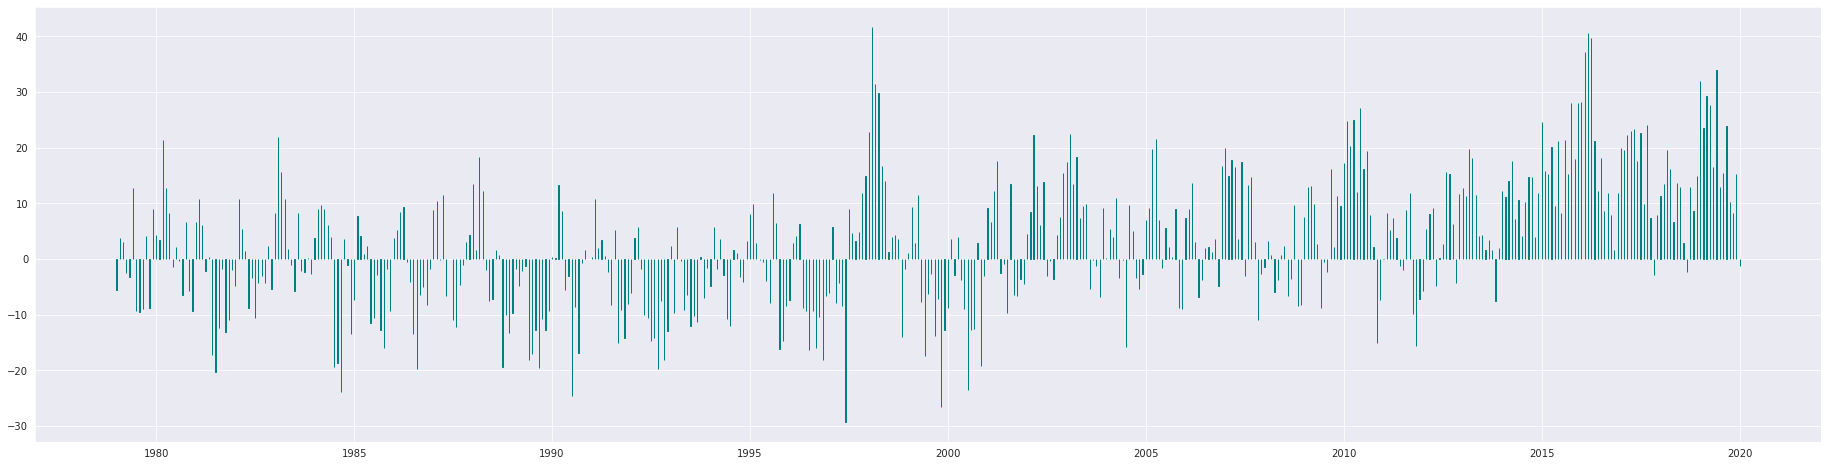

In [39]:
fig, ax = plt.subplots(figsize=(32, 8))
ax.bar(x = df_sl.index, height = df_sl['hgt'], width = 2, edgecolor = "teal")

In [29]:
df_sl

hgt
time                 
1979-01-01  -5.571830
1979-02-01   3.734549
1979-03-01   3.078452
1979-04-01  -2.467341
1979-05-01  -3.234400
...               ...
2019-09-01  23.943769
2019-10-01  10.292994
2019-11-01   8.223135
2019-12-01  15.224381
2020-01-01  -1.309669

[493 rows x 1 columns]

In [22]:
import itertools as it

#recebe os valores de vorticidade e itera entre eles em combinações de 2 e 3, exportando o índice calculado pelo
#blockix de cada combinação para a pasta 'netcdf'
indices = [v500.formatter(), v700.formatter(), v850.formatter(), hgt500.formatter()]
for i in it.combinations(indices, 2):
    
    block = blockix([i[0], i[1]], bloq='total', freq='M')
    nomes = block.attrs['vars by level']
    nome = nomes[0] + "." + nomes[1]
    
    block.to_netcdf(os.path.join(os.getcwd(), "netcdf", "blocking.index." + nome + ".nc"))

for i in it.combinations(indices, 3):
    
    block = blockix([i[0], i[1], i[2]], bloq='total', freq='M')
    nomes = block.attrs['vars by level']
    nome = nomes[0] + "." + nomes[1] + "." + nomes[2]
    block.to_netcdf(os.path.join(os.getcwd(), "netcdf", "blocking.index." + nome + ".nc"))

for i in it.combinations(indices, 4):
    
    block = blockix([i[0], i[1], i[2], i[3]], bloq='total', freq='M')
    nomes = block.attrs['vars by level']
    nome = nomes[0] + "." + nomes[1] + "." + nomes[2] + nomes[3]
    block.to_netcdf(os.path.join(os.getcwd(), "netcdf", "blocking.index." + nome + ".nc"))

#...de idem quando avaliado em apenas um nível
for i in indices:
    
    block = blockix(i, bloq='total', freq='M')
    nomes = block.attrs['vars by level']
    nome = nomes[0]
    block.to_netcdf(os.path.join(os.getcwd(), "netcdf", "blocking.index." + nome + ".nc"))

# SÉRIES TEMPORAIS

In [132]:
def aave_ts_plot(dsmean, stats = True, serie='série histórica'):
    
    #extraindo a string da variável para atribuir o nome no título e manipular o data array 
    dataset = dsmean.to_array().isel(variable=0)
    var = str(dataset["variable"].values)
    
    #extraindo o valor de latitude nos atributos para verificar a área de estudo (mostrado no título)
    if dsmean.attrs['lat'] == '-10.0 to -25.0 degrees':
        area = "Área total"
    elif dsmean.attrs['lat'] == '-10.0 to -17.5 degrees':
        area = "Setor norte"
    elif dsmean.attrs['lat'] == '-17.5 to -25.0 degrees':
        area = "Setor sul"
    
    #valor do level para o título
    level = dsmean.attrs['level']
    
    #nome, unidade e escala (vorticidade possui valores muito pequenos)
    if var == 'hgt':
        name = 'anomalia gepotencial'
        unidade = 'm'
        escala = 1
    elif var == 'vort':
        escala = 10**5
        name = 'vorticidade'
        unidade = "$10^{-6}$ $s^{-1}$"
    elif var == 'índice de bloqueios':
        name = var
        unidade = ""
        escala = 1
        level = None

    fig, ax = plt.subplots(figsize=(32,6))
    ax.set_ylabel(unidade, fontsize=25)
    
    ax_color = 'white' #cor do axes
    plot_color = "teal" #cor do gráfico
    av_color = 'teal' #cor da linha média
    thresh_color = 'teal' #cor dos limites
    year_color = '#E63946' #análise de ano
    
    fig.patch.set_alpha(1) #figura transparente
    ax.patch.set_color(ax_color) #axes na cor ax_color
    ax.patch.set_alpha(1) #transparência do axes
    
    #o dataset é multiplicado pela escala e, em seguida, é feito o resample dos dados diários para a média mensal
    dsmean = dsmean*escala
    dsmean = dsmean.resample(time="MS").mean()

    dfmean = dsmean.drop('level').to_dataframe()
    
    dfmean = recorte(dfmean, serie=serie)
    
    ax.plot(dfmean, color = plot_color)
    
    if stats == True:
        average = np.mean(dfmean)
        std = np.std(dfmean)
        maximum = average + 2*std
        minimum = average - 2*std
        
        stats = {'min': minimum.values[0], 'mean': average.values[0], 'max': maximum.values[0]}

    ax.axhline(y=stats['mean'], color=av_color, linestyle="-", label = 'média')
    ax.axhline(y=stats['max'], color=thresh_color, linestyle=":", linewidth = 2, label='média + 2σ')
    ax.axhline(y=stats['min'], color=thresh_color, linestyle=":", linewidth = 2, label='média - 2σ')
    
    #ax.legend(fancybox = True, loc='lower left', fontsize=18)
    plt.setp(ax.get_xmajorticklabels(), rotation=45, ha="right", fontsize=20)
    plt.setp(ax.get_ymajorticklabels(), fontsize=20)
    ax.grid(True, color = "grey", alpha = 0.7, axis = 'x', linestyle='-.', linewidth = 1)
    
    if serie == 'série histórica':
        ax.xaxis.set_major_locator(mdates.YearLocator(3))
        years_fmt = mdates.DateFormatter('%Y')
        ax.xaxis.set_major_formatter(years_fmt)
    else:
        start, end = ax.get_xlim()
        ax.xaxis.set_ticks(np.arange(start, end, 8))
    
    #fig.autofmt_xdate()

    ax.set_title("Média regional da " + name + " em " + str(level) + "hPa x Vazão natural normalizada | " + area + " | " + serie.capitalize() + "\n", fontsize=30, style = 'oblique')
    fig.tight_layout()
    plt.savefig('aave_timeseries' + name + str(level) + area + serie)
    return fig, ax

In [3]:
vort850 = v850.formatter().aave().dataset
vort700 = v700.formatter().aave().dataset
hgt500 = hgt500.formatter().aave().dataset

In [148]:
def plot(ds, df, serie):
    fig, ax = aave_ts_plot(ds, serie = serie)
    sns.set_style('whitegrid')
    
    #extraindo a string da variável para atribuir o nome no título e manipular o data array 
    dataset = ds.to_array().isel(variable=0)
    var = str(dataset["variable"].values)

    #criando um axes gêmeo, com o eixo y do outro lado do plot
    ax2 = ax.twinx()
    bbox = (0, 0.67, 1, 0.5)
    
    #definindo um cmap padrão pro ax referente às vazões nas usinas
    #colors=["#2A5054", "darkslategrey", "dodgerblue", "olive", 
    #    "purple"]
    #cvaz = mpl.colors.ListedColormap(colors)
    #clist = []
    #cmap = plt.get_cmap('afmhot', 5)    # PiYG

    #for i in range(cmap.N):
    #    rgb = cmap(i)[:3] # will return rgba, we take only first 3 so we get rgb
    #    clist.append(matplotlib.colors.rgb2hex(rgb))
        
    #cmap = plt.get_cmap(colors)  # type: matplotlib.colors.ListedColormap
    #colors = cmap.colors  # type: list
    #ax2.set_prop_cycle(color=colors)
    
    
    #definindo um cmap padrão pro ax referente às vazões nas usinas
    #colors=["#fcde9c","#faa476","#f0746e","#e34f6f","#dc3977","#b9257a","#7c1d6f"]
    #colors = ["#855C75","#736F4C","#526A83","#9C9C5E","#A06177","#8C785D","#467378","#7C7C7C"]
    colors = ["darkgoldenrod","#99C945","#CC61B0","#24796C","#DAA51B","#2F8AC4","#764E9F","#ED645A","#CC3A8E","#A5AA99"]
    cvaz = mpl.colors.ListedColormap(colors)
    cmap = plt.get_cmap(cvaz)  # type: matplotlib.colors.ListedColormap
    colors = cmap.colors  # type: list
    ax2.set_prop_cycle(color=colors)
    
    
    
    ax2.plot(np.nan, label=var + " em " + str(int(ds.level.values)) + "hPa", color = "teal")
    for usina in df.columns:
        ax2.plot(df[usina], label=usina)

    #recebe as datas inicial e final do eixo x do twinx() pra reajustar o axis do gráfico, quando o recorte
    #da análise não compreende toda a série temporal. Isso acontece porque para que possamos plotar sem 
    #lacunas ao avaliar períodos recortados (por exemplo, o período úmido), o índice do dataframe se torna
    #categorizado, ou seja, seu tipo não é data. Dessa forma, atribui-se o objeto do índice sem que o eixo x
    #tente organizá-las temporalmente (as datas ficam organizadas com passo 8 entre si)
    if serie != 'série histórica':
        start, end = ax2.get_xlim()
        ax2.xaxis.set_ticks(np.arange(start, end, 8))

    #alocando a legenda e configurando os axes
    ax2.legend(loc='upper left', bbox_to_anchor=bbox, fontsize=20, fancybox=True, framealpha=0.5, mode='expand', ncol=len(df.columns) + 1)
    plt.setp(ax.get_xmajorticklabels(), rotation=45, ha="right", fontsize=20)

    ax2.get_yaxis().set_tick_params(which='major', pad=15, labelsize=25)

    #transformando o número de dias de bloqueio retornado pelo loess em int no eixo y do twinx()
    #ax2.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax2.set_ylabel("Vazão normalizada", size=24, color='black', labelpad = 30, rotation = 270)
    #ax2.set_ylim(0, 30)

    ax.tick_params(axis='y', colors='black')
    ax2.tick_params(axis='y', colors='black')
    ax2.grid(None)
    ax.grid(None)
    ax.grid(True, color = "grey", alpha = 0.7, axis = 'x', linestyle='-.', linewidth = 1)
    namefig = ax.get_title()
    fig.tight_layout()
    plt.savefig(usina + namefig + '.png')



In [153]:
df = dfvazoes(serie = 'período úmido', usinas=['111'])

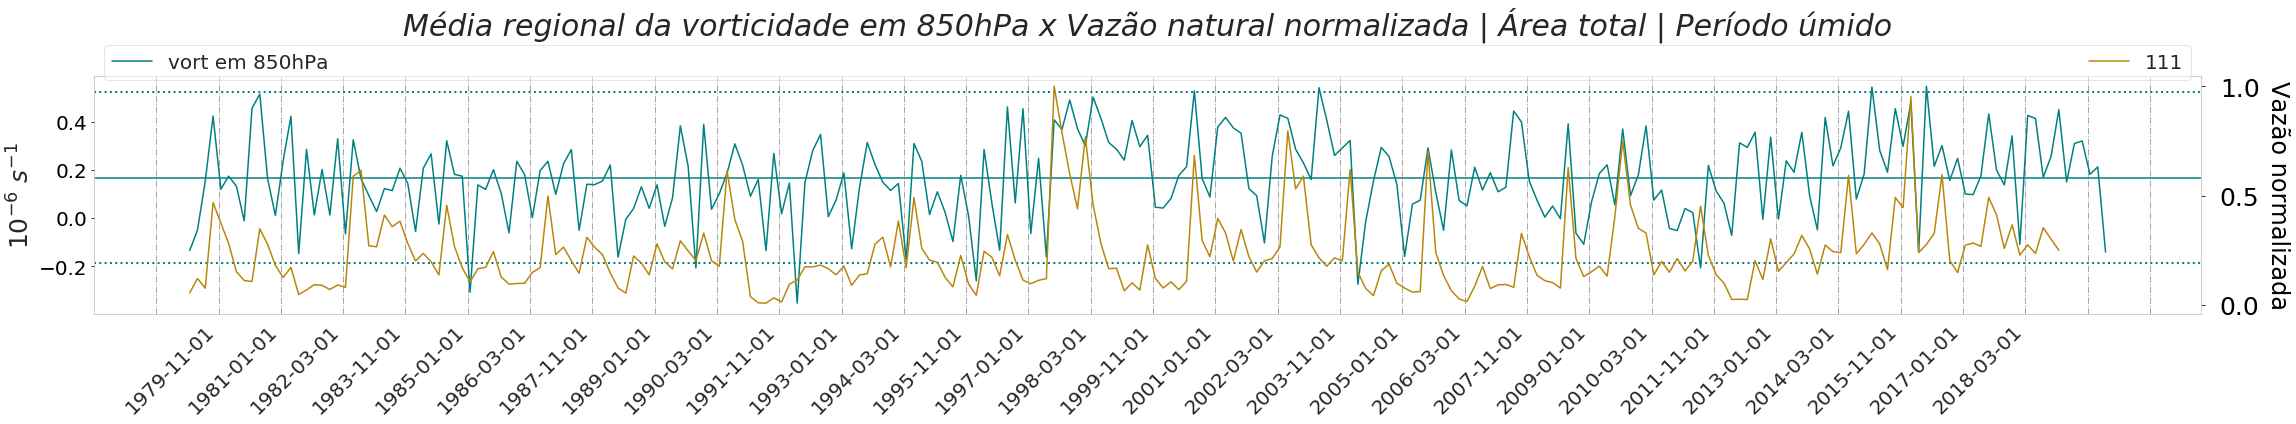

In [154]:
plot(vort850, df, serie = 'período úmido')

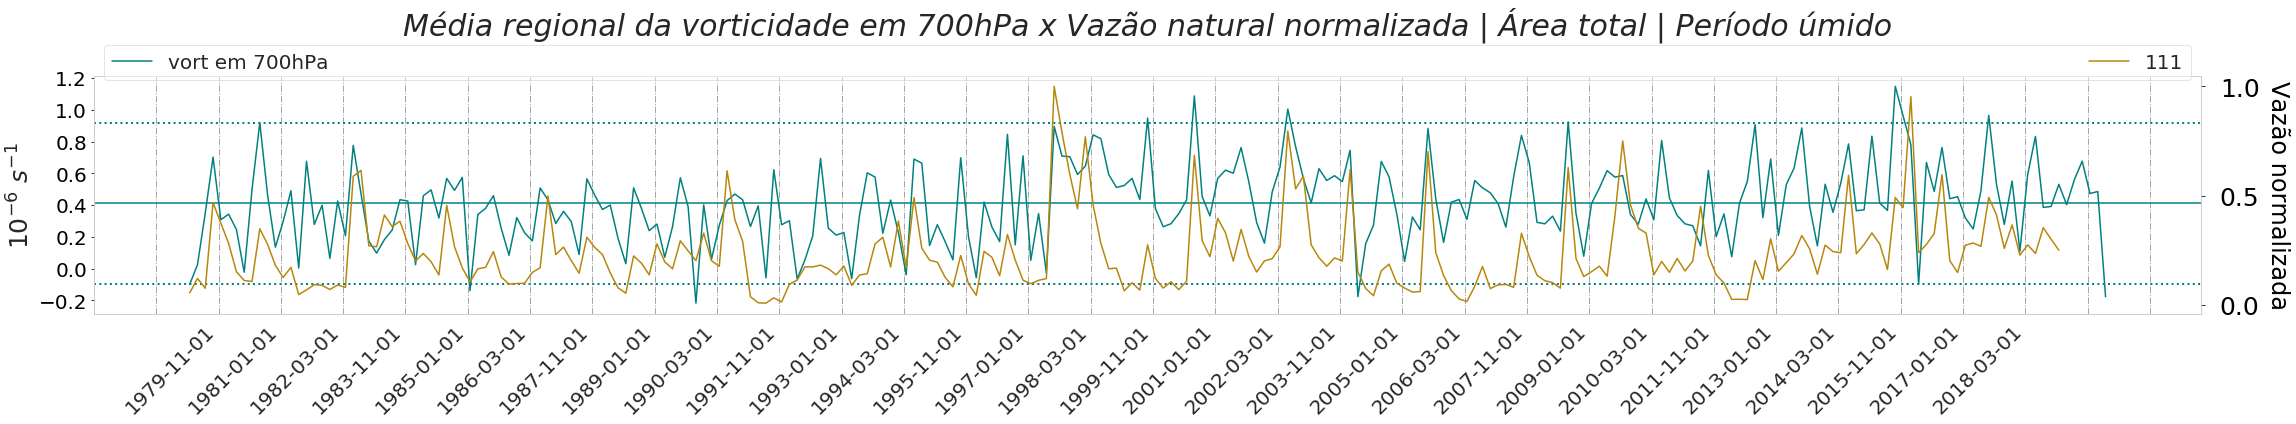

In [155]:
plot(vort700, df, serie = 'período úmido')

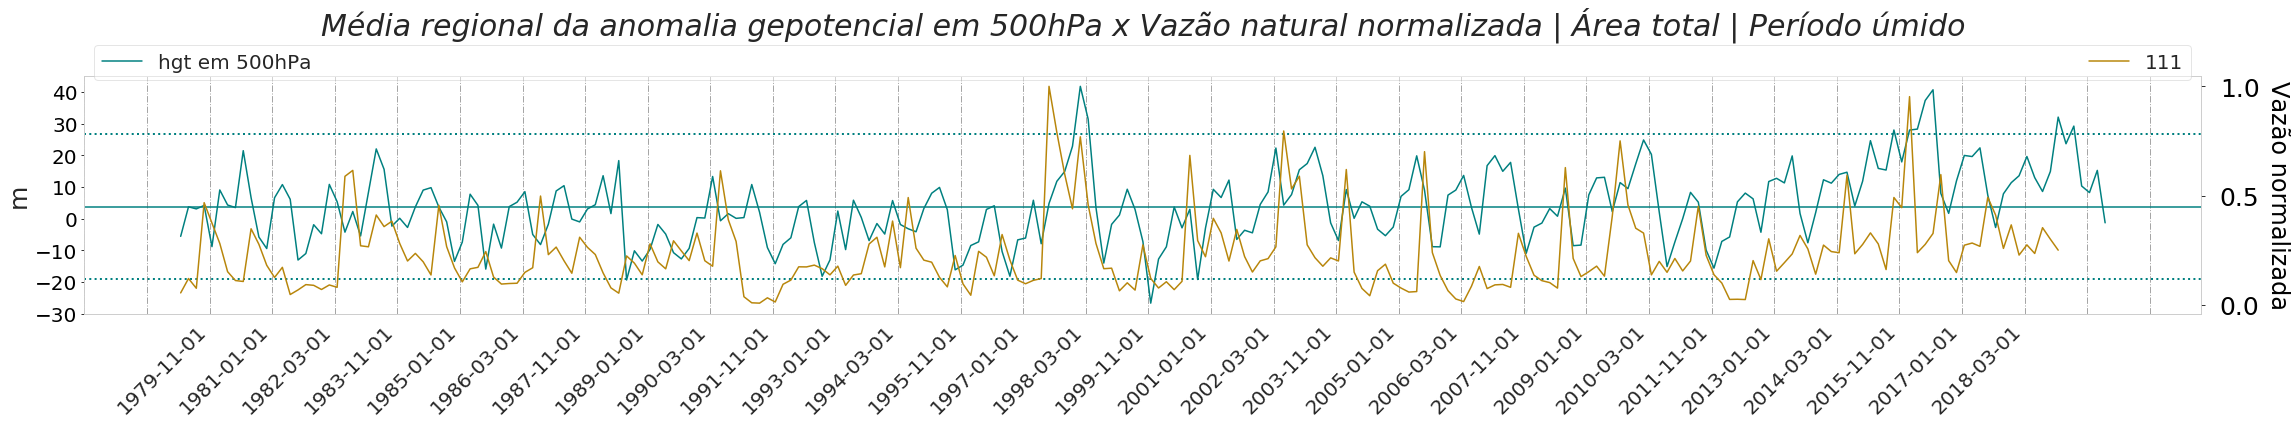

In [156]:
plot(hgt500, df, serie = 'período úmido')

# DECOMPOSIÇÃO DE LOESS X PERSISTÊNCIA DE VORTICIDADE

##### allblock(tipos, series, savefig) >>>>> FOI SUBSTITUÍDO PELO IXCOMPARISON
#### ixcomparison(tipos, series, how, specify_vars, savefig)
Plota todos os índices de bloqueios criados a partir da combinação de levels
##### loess_vaz(usinas, tipos, series, savefig)
Comparação da decomposição de loess do índice de bloqueios com a vazão em um plot de dois eixos
##### loess_vaz_plot(df, dfloess, serie, tipo, savefig)
Plot da comparação do loess_vaz
##### loess(dfix, tipo, serie, recorte, sazonalidade, periodo, robusto, grau_sazonalidade, grau_tendencia, grau_filtro)
Cálculo da decomposição de loess a partir de um dataframe.
##### loessplot(ds, tipo, ds_2, serie, sazonalidade, periodo, ylim, robusto, grau_sazonalidade, grau_tendencia, grau_filtro, ds_2_label)
Plot único de decomposição. Pode receber até dois datasets.

In [8]:
def ixcomparison(tipos, series, how = None, specify_vars=None, savefig = False):
    for serie in series:
        for tipo in tipos:
            
            #criamos uma figura para cada tipo de análise em cada série
            fig, ax = plt.subplots(figsize=(32, 8))
            
            bbox = (0, 0.678, 1, 0.5)
            labels = []

            fig.patch.set_alpha(0)
            ax.patch.set_alpha(0.5)
            ax.set_ylim(0, 30)
            ax.set_ylabel("Dias de bloqueio", size=24)
                    
            #lista-se todos os arquivos que iniciam com 'blocking.index', previamente exportados para a pasta
            #"netcdf", lendo todos os arquivos de combinação de índice de bloqueio.
            for arquivo in os.listdir(os.path.join(os.getcwd(), "netcdf")):
                if arquivo.startswith("blocking.index"):
                    
                    block = xr.open_dataset(os.path.join(os.getcwd(), "netcdf", arquivo))
                       
                    if how == 1:
                        if len(block.attrs['vars by level']) == 1 or type(block.attrs['vars by level']) == str:
                            ax.plot(loess(block.to_dataframe(), serie = serie, tipo = tipo, recorte=True), label=block.attrs['vars by level'])#, label=str(block.to_array().isel(variable=0)['variable'].values) + str(int(block.level[0])) + " | " + str(block.to_array().isel(variable=0)['variable'].values) + str(int(block.level[0])) + " hPa")
                            labels.append(block.attrs['vars by level'])
                            
                    elif how == 2:
                        if len(block.attrs['vars by level']) == 2:
                            ax.plot(loess(block.to_dataframe(), serie = serie, tipo = tipo, recorte=True), label=block.attrs['vars by level'])
                            labels.append(block.attrs['vars by level'])
                                
                    elif how == 3:
                        if type(block.attrs['vars by level']) == list and len(block.attrs['vars by level']) >= 3:
                            ax.plot(loess(block.to_dataframe(), serie = serie, tipo = tipo, recorte=True), label=block.attrs['vars by level'])
                            labels.append(block.attrs['vars by level'])

                    elif how == 'all':
                        ax.plot(loess(block.to_dataframe(), serie = serie, tipo = tipo, recorte=True), label=block.attrs['vars by level'])#, label=str(block.to_array().isel(variable=0)['variable'].values) + str(int(block.level[0])) + " | " + str(block.to_array().isel(variable=0)['variable'].values) + str(int(block.level[0])) + " hPa")
                        labels.append(block.attrs['vars by level'])

                    elif specify_vars != None and how == None:
                        if type(specify_vars) == list:
                            if set(specify_vars) == set(block.attrs['vars by level']):
                                ax.plot(loess(block.to_dataframe(), serie = serie, tipo = tipo, recorte=True), label=block.attrs['vars by level'])#, label=str(block.to_array().isel(variable=0)['variable'].values) + str(int(block.level[0])) + " | " + str(block.to_array().isel(variable=0)['variable'].values) + str(int(block.level[0])) + " hPa")
                                labels.append(block.attrs['vars by level'])

                    #legenda e configurações de plotagem e eixos categorizados (ver as outras funções desta seção)
                    ax.legend(loc='upper left', bbox_to_anchor=bbox, mode = "expand", ncol = len(labels), framealpha=0.5, fontsize=20)
                    plt.setp(ax.get_xmajorticklabels(), rotation=45, ha="right", fontsize=20)
                    if serie != 'série histórica':
                        start, end = ax.get_xlim()
                        ax.xaxis.set_ticks(np.arange(start, end, 8))
                    ax.get_yaxis().set_tick_params(which='major', pad=15, labelsize=25)

            #nome para o título baseado no recorte de latitude do dataset, localizado nos atributos
            if block.lat == "-10.0 to -25.0 degrees":
                bloq_name_title = "Área total"

            elif block.lat == "-17.5 to -25.0 degrees":
                bloq_name_title = "Setor sul"

            elif block.lat == "-10.0 to -17.5 degrees":
                bloq_name_title = "Setor norte"
            
            #checa se o recorte da série temporal é uma lista de meses. Caso seja, retorna o nome dos meses abreviados
            #no título e no arquivo de exportação, caso savefig=True. Caso não seja uma lista, retorna o recorte da série 
            #em ambos
            if type(serie) != list:
                title = "Comparação entre dias de bloqueio baseado em diferentes índices \n " + bloq_name_title + " | " + tipo.capitalize() + " | " + serie.capitalize() + "\n\n"
            else:
                title = "Comparação entre dias de bloqueio baseado em diferentes índices \n " + bloq_name_title + " | " + tipo.capitalize() + " | " + calendar.month_abbr[serie[1]] + " - " + calendar.month_abbr[serie[0]] + "\n\n"
            
            ax.set_title(title, fontsize = 30, style = 'oblique')
            fig.tight_layout()
            
            if savefig == True:
                plt.savefig(title + str(how) + '.png')

In [9]:
def simplecorr(specify_vars = None, how=1, time=['1979-01-01', '2018-12-01'], savefig = False, mes = None):
    
    dfblocks = []
    blockrows = []
    vazrows = []
    height = 10 
    for arquivo in os.listdir(os.path.join(os.getcwd(), "netcdf")):
        if arquivo.startswith("blocking.index"):
            block = xr.open_dataset(os.path.join(os.getcwd(), "netcdf", arquivo)).sel(time=slice(time[0], time[1]))
            dfblock = block.to_dataframe()
            lat = block.attrs['lat']

            if how == 1:
                if len(block.attrs['vars by level']) == 1 or type(block.attrs['vars by level']) == str:
                    dfblock = dfblock.rename(columns = {'bloqueios': str(block.attrs['vars by level'])})
                    dfblocks.append(dfblock)
                    blockrows.append(dfblock.columns.values[0])

            elif how == 2:
                if len(block.attrs['vars by level']) == 2:
                    dfblock = dfblock.rename(columns = {'bloqueios': str(block.attrs['vars by level'])})
                    dfblocks.append(dfblock)
                    blockrows.append(dfblock.columns.values[0])

            elif how == 3:
                if type(block.attrs['vars by level']) == list and len(block.attrs['vars by level']) >= 3:
                    dfblock = dfblock.rename(columns = {'bloqueios': str(block.attrs['vars by level'])})
                    dfblocks.append(dfblock)
                    blockrows.append(dfblock.columns.values[0])

            elif how == 'all':
                height = 24
                dfblock = dfblock.rename(columns = {'bloqueios': str(block.attrs['vars by level'])})
                dfblocks.append(dfblock)
                blockrows.append(dfblock.columns.values[0])


            elif specify_vars != None and how == None:
                if type(specify_vars) == list:
                    if set(specify_vars) == set(block.attrs['vars by level']):
                        dfblock = dfblock.rename(columns = {'bloqueios': str(block.attrs['vars by level'])})
                        dfblocks.append(dfblock)
                        blockrows.append(dfblock.columns.values[0])

    vaz_br = vazoes()[0].sel(time=slice(time[0], time[1])).to_array()
    vaz_sul = vazoes()[1].sel(time=slice(time[0], time[1])).to_array()
    vaz_total = [vaz_br, vaz_sul]
    vaz = xr.concat(vaz_total, dim="variable").to_dataset(dim="variable")
    normvaz = normalizar(vaz.resample(time='MS').mean())
    vazrows = normvaz.to_dataframe().columns.values  
    
    atmvaz = normvaz.to_dataframe().join(dfblocks)
    atmvaz.fillna(0, inplace=True)
    
    if mes != None:
        atmvaz = atmvaz[atmvaz.index.month == mes]
    
    atmvazcorr = atmvaz.corr()
    atmvazcorr.drop(blockrows, axis = 1, inplace=True)
    atmvazcorr.drop(vazrows, axis = 0, inplace=True)

    atmvazcorr = atmvazcorr.rename(columns={"246":"Porto Primavera", "34":"Ilha Solteira", "237":"Barra Bonita", "240":"Promissão", "33":"São Simão", "24":"Emborcação", "6":"Furnas", "18":"Água Vermelha", "156":"Três Marias", "168":"Sobradinho", "275":"Tucuruí", "287":"Santo Antônio", "285":"Jirau", "190":"Boa Esperança", "254":"Pedra do Cavalo", "111":"Passo Real", "217":"Machadinho", "74":"Foz do Areia", "78":"Salto Osório", "66":"Itaipu", "63":"Rosana", "61":"Capivara"})

    fig, ax = plt.subplots(figsize=(47,height))
    sns.heatmap(atmvazcorr, annot=True, annot_kws={'fontsize':27}, cbar=False, cmap="RdBu", linewidths=0.5, vmin=-1, vmax=1, center = 0)
    cbar = plt.colorbar(plt.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=-1.,vmax=1.), cmap="RdBu"), pad=0.02, orientation="vertical", ax=ax)
    cbar.ax.tick_params(labelsize=30)
    plt.xticks(rotation=45, fontsize=30, ha="right")
    plt.yticks(rotation=0, fontsize=30)
    
    if lat == '-10.0 to -25.0 degrees':
        area = "Área total"
    
    elif lat == '-10.0 to -17.5 degrees':
        area = "Setor norte"
    
    elif lat == '-17.5 to -25.0 degrees':
        area = "Setor sul"
        
    ax.set_title("Dias de bloqueio x Vazão natural (normalizado)\nPeríodo de " + time[0][:4] + " a " + time[1][:4] + " | " + calendar.month_abbr[mes].upper() + " | " + area + "\n", fontsize = 40, style = 'oblique')

    fig.tight_layout()
    
    if savefig == True:
        plt.savefig("Dias de bloqueio x Vazão natural (normalizado)" + str(how) + str(time) + str(mes) + area + ".png", transparent = True)

In [10]:
def loess(dfix, tipo = 'tendência', serie = 'período úmido', filtro_mes = True, sazonalidade=7, periodo=6, robusto=False, grau_sazonalidade=1, grau_tendencia=1, grau_filtro=1):
    #Função que recorta um dataframe de acordo com o recorte de série caso recorte = True e calcula a decomposição
    #de loess de acordo com o tipo de análise ('tendência', 'sazonalidade', 'residual', 'observado')
    
    #recorte dos dados e set da sazonalidade e período de acordo com o intervalo da série temporal resultante
    if filtro_mes == True:
        df = recorte(dfix, serie = serie)
        
    else: #caso o recorte não seja requerido pelo usuário por algum motivo, recebe o dataframe puro
        df = dfix
    
    #decomposição de loess
    stl = STL(df, seasonal=sazonalidade, period=periodo, robust=robusto, seasonal_deg=grau_sazonalidade,
             trend_deg=grau_tendencia, low_pass_deg=grau_filtro)
    res = stl.fit()
    
    #retorna resultado de acordo com o tipo de análise
    if tipo == 'tendência':
        res = res.trend
    elif tipo == 'sazonalidade':
        res = res.seasonal
    elif tipo == 'observado':
        res = res.observed
    elif tipo == 'residual':
        res = res.resid
        
    return res

In [11]:
def loessplot(ds, tipo, ds_2 = None, serie=None, sazonalidade=9, periodo=6, ylim = None, robusto=False, grau_sazonalidade=1, grau_tendencia=1, grau_filtro=1):
    #Função que recebe até dois datasets, o recorte desejado da série e o tipo de análise e retorna o plot da
    #decomposição de loess do(s) dataset(s) fornecidos
    
    #recebe até 2 datasets e os transforma em dataframe
    indice_div_vort = ds    
    df = ds.to_dataframe()
    #o segundo dataset foi inicialmente tratado como um bloqueio avaliado no setor SUL. (a modificar)
    if ds_2 != None:
        indice_div_vort2 = ds_2
        df2 = ds_2.to_dataframe()
    
    #criando a figura
    fig, ax = plt.subplots(figsize=(32,8))
    
    fig.patch.set_alpha(0)
    ax.patch.set_alpha(0.5)
            
    ax.set_ylabel("Dias de bloqueio", size=24)
    ax.set_ylim(0, 30)
    
    #definindo um cmap padrão pro ax referente às vazões nas usinas
    colors=["#8A2551", "darkgoldenrod", 'tab:green', "k", 
        "purple"]
    cvaz = mpl.colors.ListedColormap(colors)
    cmap = plt.get_cmap(cvaz)  # type: matplotlib.colors.ListedColormap
    colors = cmap.colors  # type: list
    ax.set_prop_cycle(color=colors)
    
  
    #checando variável e level para o título e exportação da figura 
    if type(ds.attrs['vars by level']) == list:
        if len(ds.attrs['vars by level']) == 2:
            varlevel = ds.attrs['vars by level'][0] + "hPa e " + ds.attrs['vars by level'][1] + "hPa"
        elif len(ds.attrs['vars by level']) == 3:
            varlevel = ds.attrs['vars by level'][0] + "hPa, " + ds.attrs['vars by level'][1] + "hPa e " + ds.attrs['vars by level'][2] + "hPa"
        elif len(ds.attrs['vars by level']) == 4:
            varlevel = ds.attrs['vars by level'][0] + "hPa, " + ds.attrs['vars by level'][1] + "hPa, " + ds.attrs['vars by level'][2] + "hPa e " + ds.attrs['vars by level'][3] + "hPa"
        elif len(ds.attrs['vars by level']) == 1:
            varlevel = ds.attrs['vars by level'][0] + "hPa"
    elif type(ds.attrs['vars by level']) == str:
            varlevel = ds.attrs['vars by level'] + "hPa"
    
    #em caso de um único dataset, o título vai receber o nome das variávels e levels que compõem o bloqueio
    varlevel_name = varlevel
            
    if ds_2 != None:
        if type(ds_2.attrs['vars by level']) == list:
            if len(ds_2.attrs['vars by level']) == 2:
                varlevel2 = ds_2.attrs['vars by level'][0] + "hPa e " + ds_2.attrs['vars by level'][1] + "hPa"
            elif len(ds_2.attrs['vars by level']) == 3:
                varlevel2 = ds_2.attrs['vars by level'][0] + "hPa, " + ds_2.attrs['vars by level'][1] + "hPa e " + ds_2.attrs['vars by level'][2] + "hPa"
            elif len(ds_2.attrs['vars by level']) == 4:
                varlevel = ds_2.attrs['vars by level'][0] + "hPa, " + ds_2.attrs['vars by level'][1] + "hPa, " + ds_2.attrs['vars by level'][2] + "hPa e " + ds_2.attrs['vars by level'][3] + "hPa"
            elif len(ds_2.attrs['vars by level']) == 1:
                varlevel2 = ds_2.attrs['vars by level'][0] + "hPa"
                
        #se os dois datasets apresentam a mesma variável e nos mesmos levels, no caso de uma comparação de
        #áreas diferentes de estudo pra região de bloqueios, o nome mostrado no título vai ser o mesmo 
        #pra ambas. Caso contrário, o título leva uma string de comparação Varlevel1 x Varlevel2
        if varlevel2 == varlevel:
            varlevel_name = varlevel
        else:
            varlevel_name = varlevel + " x " + varlevel2
    
    #tenta receber o valor do recorte de longitude do dataset para definir qual a região de estudo em que
    #está sendo trabalhada a decomposição temporal. Caso não seja possível determinar a latitude, este 
    #atributo de título ficará vazio
    try:
        if ds_2 != None:
            #se os dois datasets tiverem o mesmo atributo de latitude, eles estão sendo avaliados na mesma área
            #isso significa que o título (bloq_name_title) deve apresentar a string correspondente à região de 
            #estudo, enquanto as labels (bloq_name) devem mostrar as variáveis e levels no qual o bloqueio foi
            #avaliado (varlevel e varlevel2). Considerando que, para uma mesma região, se avaliam diferentes
            #datasets (não faz sentido comparar dois datasets da mesma região com o mesmo varlevel)
            if indice_div_vort.attrs['lat'] == indice_div_vort2.attrs['lat']:
                if indice_div_vort.attrs['lat'] == "-10.0 to -25.0 degrees" :
                    bloq_name_title = " | Área total"

                if indice_div_vort.attrs['lat'] == '-10.0 to -17.5 degrees':
                    bloq_name_title = " | Setor norte"

                if indice_div_vort.attrs['lat'] == '-17.5 to -25.0 degrees':
                    bloq_name_title = "| Setor sul"

                bloq_name = varlevel
                bloq_name2 = varlevel2

            #se os dois datasets tem atributos diferentes de latitude, ou seja, estão avaliando regiões diferentes
            #de bloqueio, a área tem que ser incluída no label (bloq_name) junto à variável e o level. Neste caso
            #podem ser avaliados: 
            #1. dois datasets compostos de diferentes variáveis/levels, em áreas diferentes;
            #>>> bloq_name_title = ''
            #>>> bloq_name = nome_da_area + varlevel
            #>>> bloq_name2 = nome_da_area2 + varlevel2
            #2. dois datasets compostos pelas mesmas variáveis/levels, em áreas diferentes.
            #>>> bloq_name_title = '' #o título já leva o nome do varlevel
            #>>> bloq_name = nome_da_area
            #>>> bloq_name - nome_da_area2
            if indice_div_vort.attrs['lat'] != indice_div_vort2.attrs['lat']:
                if varlevel != varlevel2:
                    bloq_name_title = ''
                    if indice_div_vort.attrs['lat'] == "-10.0 to -25.0 degrees" :
                        bloq_name = "Área total: " + varlevel
                    if indice_div_vort.attrs['lat'] == '-10.0 to -17.5 degrees':
                        bloq_name = "Setor norte: " + varlevel
                    if indice_div_vort.attrs['lat'] == '-17.5 to -25.0 degrees':
                        bloq_name = "Setor sul: " + varlevel

                    if indice_div_vort2.attrs['lat'] == "-10.0 to -25.0 degrees" :
                        bloq_name2 = "Área total: " + varlevel2
                    if indice_div_vort2.attrs['lat'] == '-10.0 to -17.5 degrees':
                        bloq_name2 = "Setor norte: " + varlevel2
                    if indice_div_vort2.attrs['lat'] == '-17.5 to -25.0 degrees':
                        bloq_name2 = "Setor sul: " + varlevel2

                else:
                    bloq_name_title = ""
                    if indice_div_vort.attrs['lat'] == "-10.0 to -25.0 degrees" :
                        bloq_name = "Área total"
                    if indice_div_vort.attrs['lat'] == '-10.0 to -17.5 degrees':
                        bloq_name = "Setor norte"
                    if indice_div_vort.attrs['lat'] == '-17.5 to -25.0 degrees':
                        bloq_name = "Setor sul"

                    if indice_div_vort2.attrs['lat'] == "-10.0 to -25.0 degrees" :
                        bloq_name2 = "Área total"
                    if indice_div_vort2.attrs['lat'] == '-10.0 to -17.5 degrees':
                        bloq_name2 = "Setor norte"
                    if indice_div_vort2.attrs['lat'] == '-17.5 to -25.0 degrees':
                        bloq_name2 = "Setor sul"


        else:
            if indice_div_vort.attrs['lat'] == "-10.0 to -25.0 degrees":
                bloq_name = varlevel
                bloq_name_title = " | Área total"
                color = '#1E7099'
            if indice_div_vort.attrs['lat'] == '-10.0 to -17.5 degrees':
                bloq_name = varlevel
                bloq_name_title = " | Setor norte"
                color = '#2A9D8F'
            if indice_div_vort.attrs['lat'] == '-17.5 to -25.0 degrees':
                bloq_name = varlevel   
                bloq_name_title = "| Setor sul"
                color = '#0E0F19'
 
    except:
        bloq_name = ''
        bloq_name_title = ''
    
    ax.plot(loess(df, tipo=tipo, filtro_mes =True, sazonalidade=sazonalidade, periodo=periodo, robusto=robusto, grau_sazonalidade=grau_sazonalidade, grau_tendencia=grau_tendencia, grau_filtro=grau_filtro), label=bloq_name)   
    if ds_2 != None:
        ax.plot(loess(df2, tipo=tipo, filtro_mes =True, sazonalidade=sazonalidade, periodo=periodo, robusto=robusto, grau_sazonalidade=grau_sazonalidade, grau_tendencia=grau_tendencia, grau_filtro=grau_filtro), label=bloq_name2)
    
    #configurando legenda e eixos
    ax.legend(loc='upper left', fontsize=20, fancybox=True, framealpha = 0.5)
    ax.get_yaxis().set_tick_params(which='major', pad=15, labelsize=25)
    plt.setp(ax.get_xmajorticklabels(), rotation=45, ha="right", fontsize=20)
  
    #configurando o eixo x para séries temporais categorizadas (que não são datetime)
    if serie != 'série histórica':
        start, end = ax.get_xlim()
        ax.xaxis.set_ticks(np.arange(start, end, 8))
                
    if type(serie) != list:
        ax.set_title(varlevel_name + "\n" + tipo.capitalize() + bloq_name_title + " | " + serie.capitalize() + "\n", fontsize=30, style='oblique')
        fig.tight_layout()
        plt.savefig("Dias de bloqueio | "  + varlevel_name + tipo.capitalize() + bloq_name_title + " | " + serie.capitalize() + '.png')
    
    else:
        ax.set_title(varlevel_name + "\n" + tipo.capitalize() + bloq_name_title + " | " + calendar.month_abbr[serie[0]].upper() + "-" + calendar.month_abbr[serie[1]].upper() + "\n", style = 'oblique', fontsize=30)
        fig.tight_layout() 
        plt.savefig("Dias de bloqueio | " + varlevel_name + tipo.capitalize() + bloq_name_title + " | " + calendar.month_abbr[serie[0]].upper() + "-" + calendar.month_abbr[serie[1]].upper() + '.png')


In [12]:
def loess_vaz(usinas, tipos, series, savefig=False):
    #Função lê os arquivos netcdf que começam com "blocking.index" referentes ao índice de bloqueio avaliado
    #em diferentes combinações de níveis isobáricos para a variável de vorticidade, previamente separados em outra função
    #além dos arquivos de vazão natural das usinas fornecidas como atributo para o parâmetro usinas, comparando,
    #dado um recorte de série temporal ('série histórica', 'período úmido' ou uma lista de dois meses através
    #do seu valor inteiro - ex: Janeiro e Dezembro: loess_vaz(usinas, tipos, [1, 2])) e um tipo de análise 
    #('sazonalidade', 'tendência', 'residual', 'observado', sendo utilizada, preferencialmente, a análise de 
    #tendência) os valores das vazões nas usinas com o número de dias de bloqueio em cada uma das combinações
    #presentes na pasta
    
    sns.set_style('whitegrid')
    
    #recebendo tanto uma lista quanto um valor
    if type(tipos) != list:
        tipos = [tipos]
    if type(series) != list:
        series = [series]
    for serie in series:
        for tipo in tipos:

            df = dfvazoes(serie=series, usinas = usinas)
            #checa todos os arquivos previamente salvos e que iniciam com blocking.index
            for arquivo in os.listdir(os.path.join(os.getcwd(), "netcdf")):
                if arquivo.startswith("blocking.index"):

                    #a partir de cada um dos arquivos, correspondentes a cada uma das combinações de séries de vorticidade
                    #positiva em diferentes níveis, abre o dataset
                    block = xr.open_dataset(os.path.join(os.getcwd(), "netcdf", arquivo))
                    #print(block.attrs['vars by level'])

                    #o loess faz o recorte da série temporal de bloqueios de acordo com o tipo de análise e período,
                    #ambos fornecidos pelos atributos serie e tipo.
                    loess_vaz_plot(df, block, serie, tipo, savefig=savefig)



In [13]:
def loess_vaz_plot(df, dfloess, serie, tipo, savefig=False):
    #Função que recebe um dataframe de vazões e um dataset de uma variável para que seja feita a decomposição de loess,
    #dados o tipo de análise e o recorte de série temporal fornecidos pelos usuário.
    
    #o dataset é transformado em dataframe e dado como argumento para a função de loess, que faz o recorte
    #(filtro_mes=True) na série de dados. >>Esse recorte não foi feito no loess_vaz<<. Lá foi feito apenas o recorte
    #das vazões, mas é basicamente a mesma coisa. (eu vou juntar tudo isso quando der tempo)
    loessdf = loess(dfloess.to_dataframe(), serie = serie, tipo = tipo, filtro_mes=True)
    
    height = 8
    bbox = (0, 0.678, 1, 0.5)
    
    #if type(dfloess.attrs['vars by level'] == list) and len(dfloess.attrs['vars by level']) == 4:
    #    height = 15
    #    bbox = (0, 0.575, 1, 0.5)
    
    #checa o tipo do atributo 'vars by level' no dataset. A lista retorna as variáveis usadas
    #para o cálculo de dias de bloqueio em seus respectivos levels. A função deste loop é 
    #destinar a variável "varlevel" nos labels de cada plot da série temporal
    if type(dfloess.attrs['vars by level']) == list:
        if len(dfloess.attrs['vars by level']) == 2:
            varlevel = dfloess.attrs['vars by level'][0] + "hPa e " + dfloess.attrs['vars by level'][1] + "hPa"
        elif len(dfloess.attrs['vars by level']) == 3:
            varlevel = dfloess.attrs['vars by level'][0] + "hPa, " + dfloess.attrs['vars by level'][1] + "hPa e " + dfloess.attrs['vars by level'][2] + "hPa"
        elif len(dfloess.attrs['vars by level']) == 4:
            varlevel = dfloess.attrs['vars by level'][0] + "hPa, " + dfloess.attrs['vars by level'][1] + "hPa, " + dfloess.attrs['vars by level'][2] + "hPa e " + dfloess.attrs['vars by level'][3] + "hPa"
        elif len(dfloess.attrs['vars by level']) == 1: 
            varlevel = dfloess.attrs['vars by level'][0] + "hPa"
    elif type(dfloess.attrs['vars by level']) == str:
        varlevel = dfloess.attrs['vars by level'] + "hPa"    

    fig, ax = plt.subplots(figsize=(32, height))
    #definindo o fundo transparente, mas o axes branco
    fig.patch.set_alpha(0)
    ax.patch.set_alpha(0.5)
    #alaranjado, amarelo, azul, preto
    #definindo um cmap padrão pro ax referente às vazões nas usinas
    colors=[ "#B6322B", "#F6AE2D",'tab:green', "k", 
        "purple"]
    cvaz = mpl.colors.ListedColormap(colors)
    cmap = plt.get_cmap(cvaz)  # type: matplotlib.colors.ListedColormap
    colors = cmap.colors  # type: list
    ax.set_prop_cycle(color=colors)
    
    #definindo a cor referente aos dias de bloqueio
    cblock = '#262C30'
    
    #plot vazio pra anexar a label do twinx() à legenda. Vem primeiro pro label ficar em primeiro na caixa de legenda
    ax.plot(np.nan, color=cblock, label = 'Dias de bloqueio (' + varlevel + ")")  
    
    #itera pelo número de colunas no dataframe de vazões, vinculando o label à usina
    nomes = []
    for usina in df.columns:
        if usina == '6':
            nome = "Furnas"
        elif usina == '74':
            nome = "Foz do Areia"
        elif usina == '168':
            nome = "Sobradinho"
        ax.plot(df[usina], label=nome)
        nomes.append(nome)
        
    #criando um axes gêmeo, com o eixo y do outro lado do plot
    ax2 = ax.twinx()
    
    #plota a decomposição de loess no axes gêmeo
    ax2.plot(loessdf, color=cblock)
    
    #recebe as datas inicial e final do eixo x do twinx() pra reajustar o axis do gráfico, quando o recorte
    #da análise não compreende toda a série temporal. Isso acontece porque para que possamos plotar sem 
    #lacunas ao avaliar períodos recortados (por exemplo, o período úmido), o índice do dataframe se torna
    #categorizado, ou seja, seu tipo não é data. Dessa forma, atribui-se o objeto do índice sem que o eixo x
    #tente organizá-las temporalmente (as datas ficam organizadas com passo 8 entre si)
    if serie != 'série histórica':
        start, end = ax2.get_xlim()
        ax2.xaxis.set_ticks(np.arange(start, end, 8))
    
    #alocando a legenda e configurando os axes
    ax.legend(loc='upper left', bbox_to_anchor=bbox, fontsize=20, fancybox=True, framealpha=0.5, mode='expand', ncol=len(df.columns) + 1)
    plt.setp(ax.get_xmajorticklabels(), rotation=45, ha="right", fontsize=20)

    ax.get_yaxis().set_tick_params(which='major', pad=15, labelsize=25)
    ax.set_ylabel("Vazão normalizada", size=24)
    
    ax2.get_yaxis().set_tick_params(which='major', pad=15, labelsize=25)
    
    #transformando o número de dias de bloqueio retornado pelo loess em int no eixo y do twinx()
    ax2.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax2.set_ylabel("Dias de bloqueio", size=24, color=cblock, labelpad = 30, rotation = 270)
    ax2.set_ylim(0, 30)
    
    ax.tick_params(axis='y', colors='black')
    ax2.tick_params(axis='y', colors=cblock)
    ax2.grid(None)
    
    #nome da área de acordo com a latitude lida no dataset
    if dfloess.lat == "-10.0 to -25.0 degrees":
        bloq_name_title = "Área total"

    elif dfloess.lat == "-17.5 to -25.0 degrees":
        bloq_name_title = "Setor sul"

    elif dfloess.lat == "-10.0 to -17.5 degrees":
        bloq_name_title = "Setor norte"

    if type(serie) != list:
        title = "Dias de bloqueio x Vazão natural das usinas \n " + bloq_name_title + " | " + tipo.capitalize() + " | " + serie.capitalize() + "\n\n"
    else:
        title = "Dias de bloqueio x Vazão natural das usinas \n " + bloq_name_title + " | " + tipo.capitalize() + " | " + calendar.month_abbr[serie[1]] + " - " + calendar.month_abbr[serie[0]] + "\n\n"
    ax.set_title(title, fontsize = 30, style = 'oblique')
    fig.tight_layout()
    if savefig == True:
        plt.savefig(title + varlevel + '.png')


                          
    return fig, ax

In [666]:
usinas = ['6', '168', '74']
tipos = ['tendência']
series = ['período úmido']

In [652]:
#VARIAVEIS DIFERENTES NA MESMA AREA
block2 = blockix([v500.formatter(), v850.formatter(), hgt500.formatter(), v700.formatter()], bloq='total', freq='M')

In [653]:
#VARIAVEIS DIFERENTES EM AREAS DIFERENTES
block3 = blockix([v500.formatter(), v850.formatter(), hgt500.formatter()], bloq='total', freq='M')

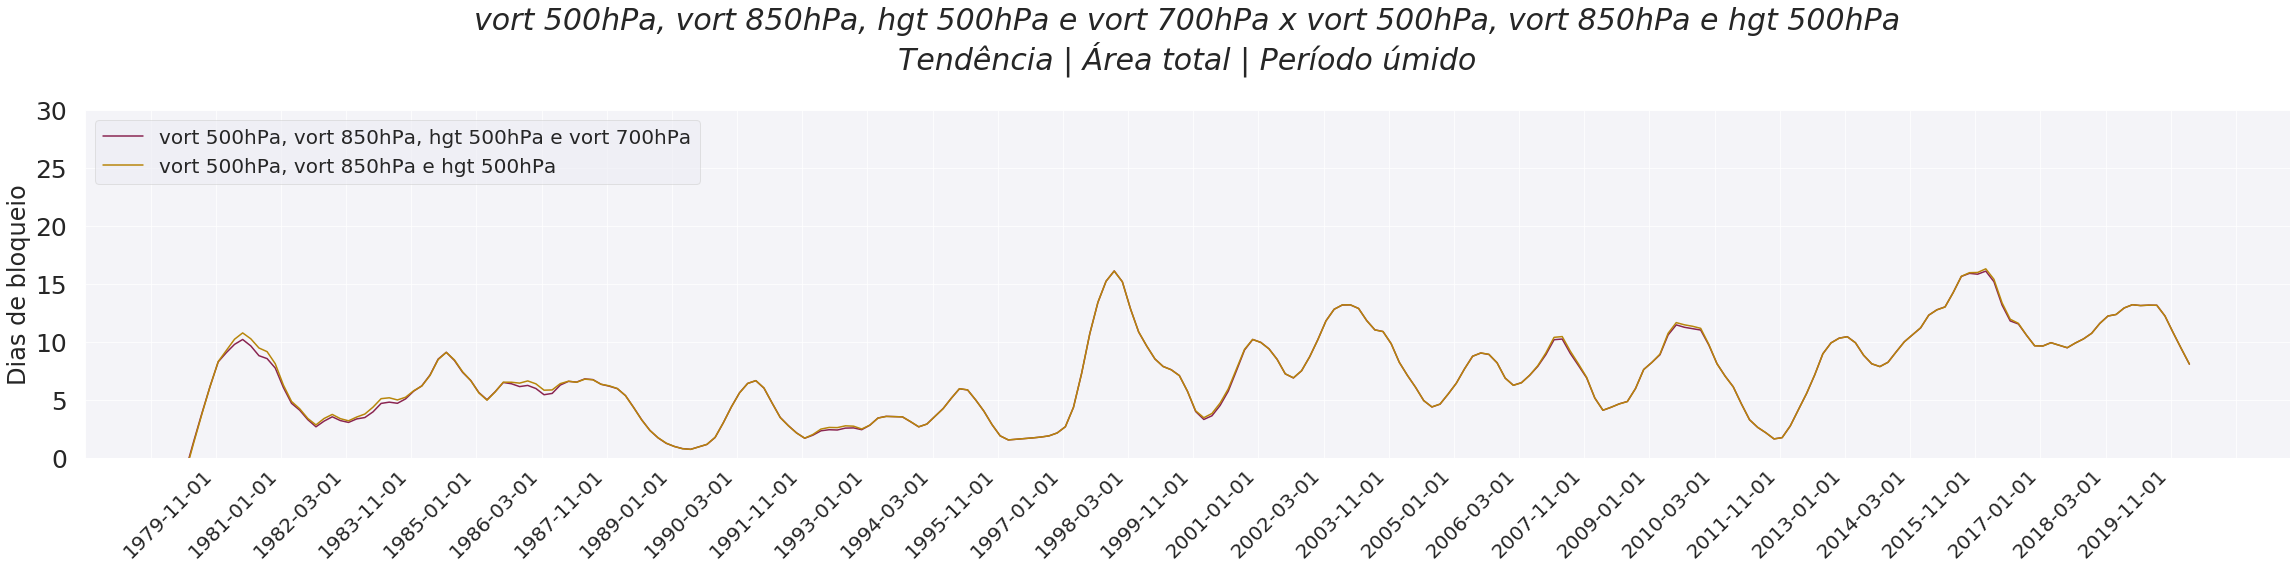

In [660]:
#comparando o que vorticidade em 700 faria com o índice 
loessplot(block2, ds_2 = block3, tipo = 'tendência', serie = 'período úmido')

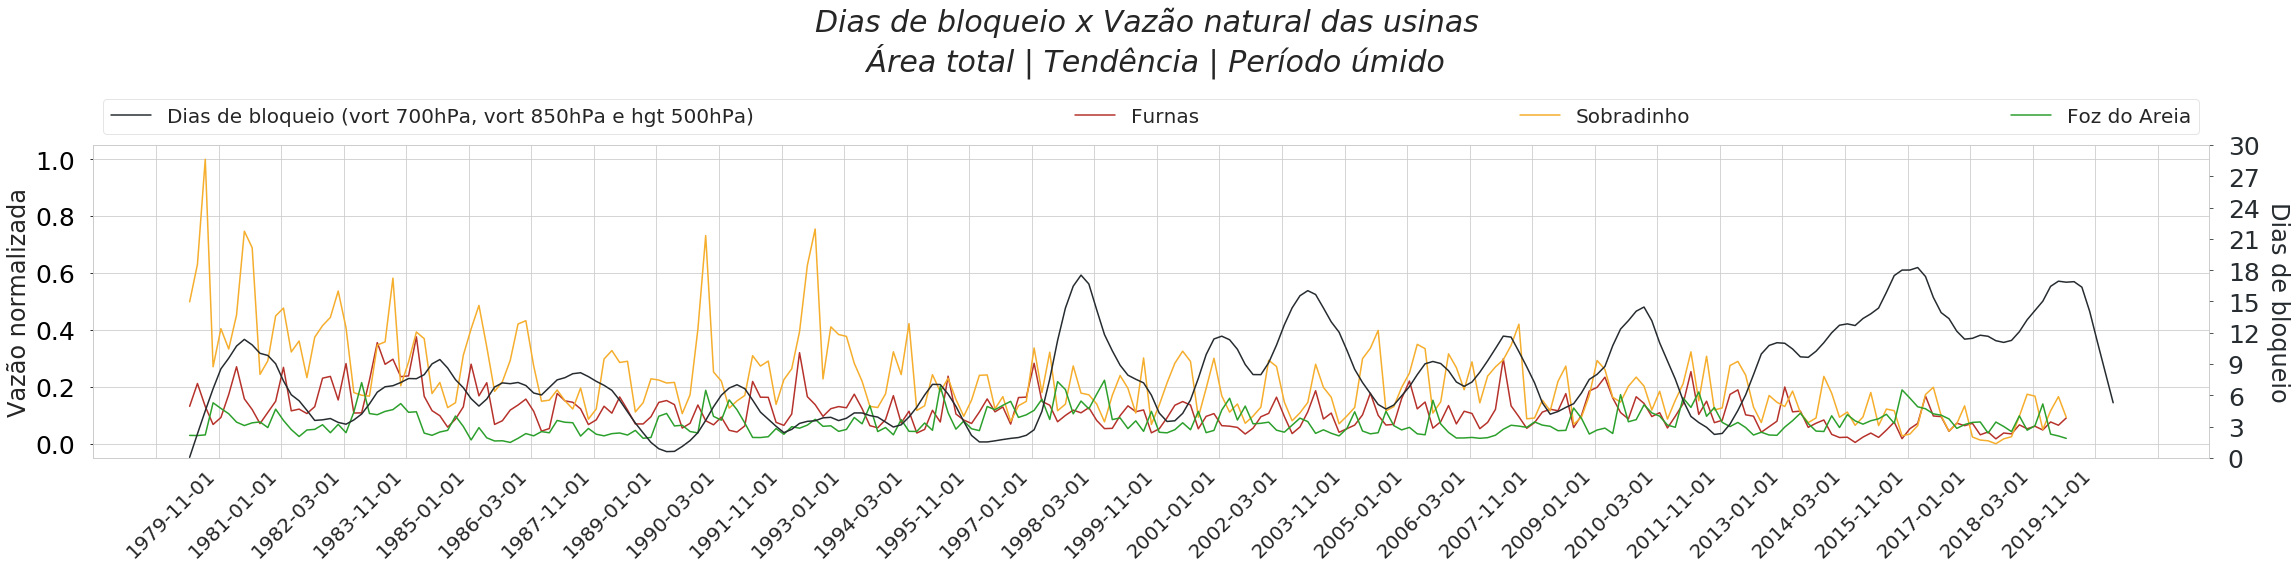

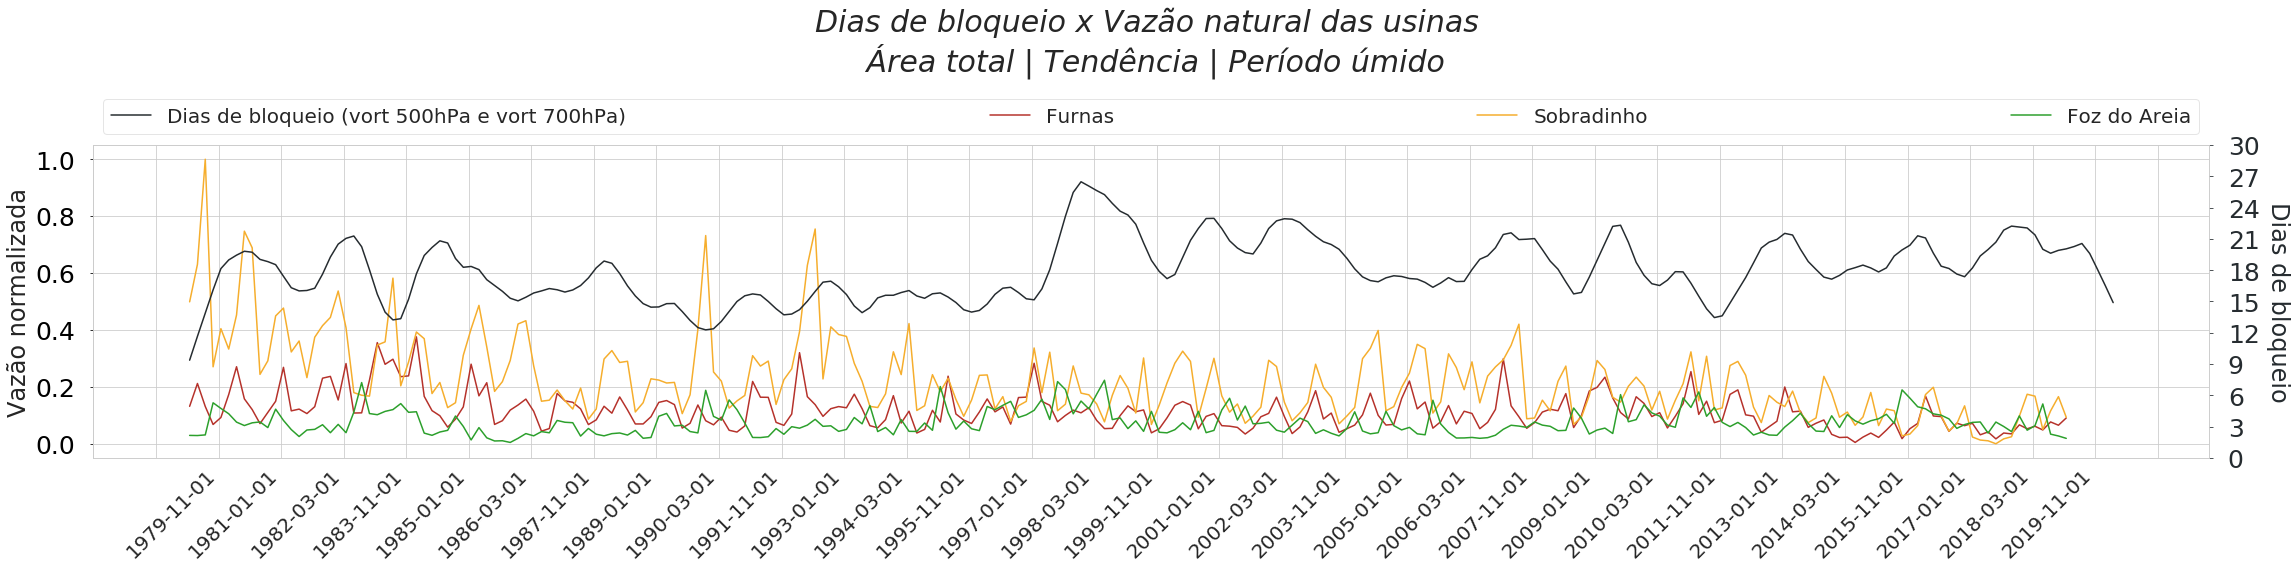

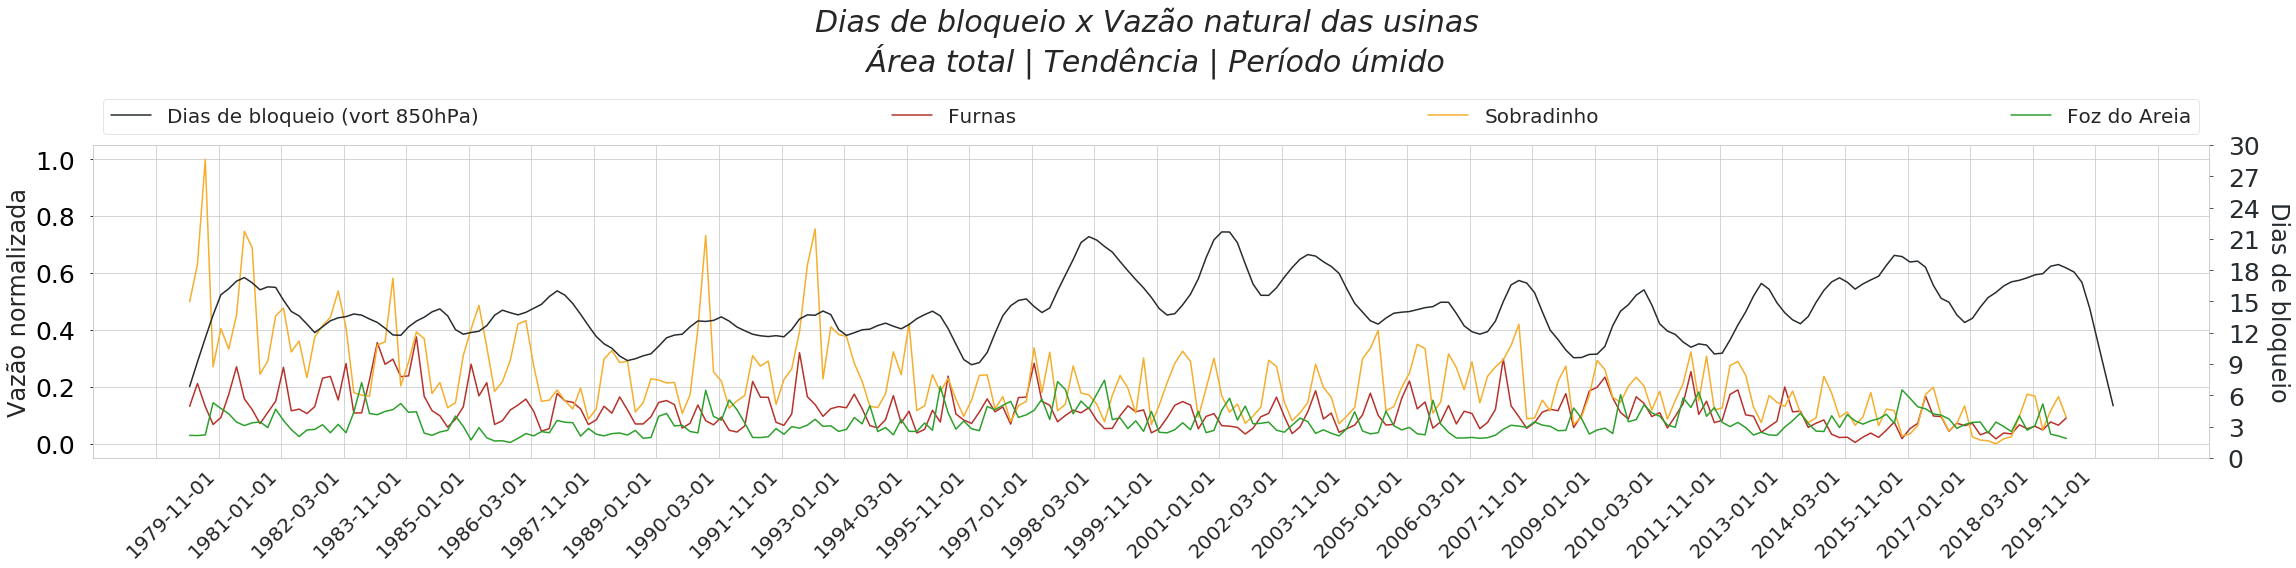

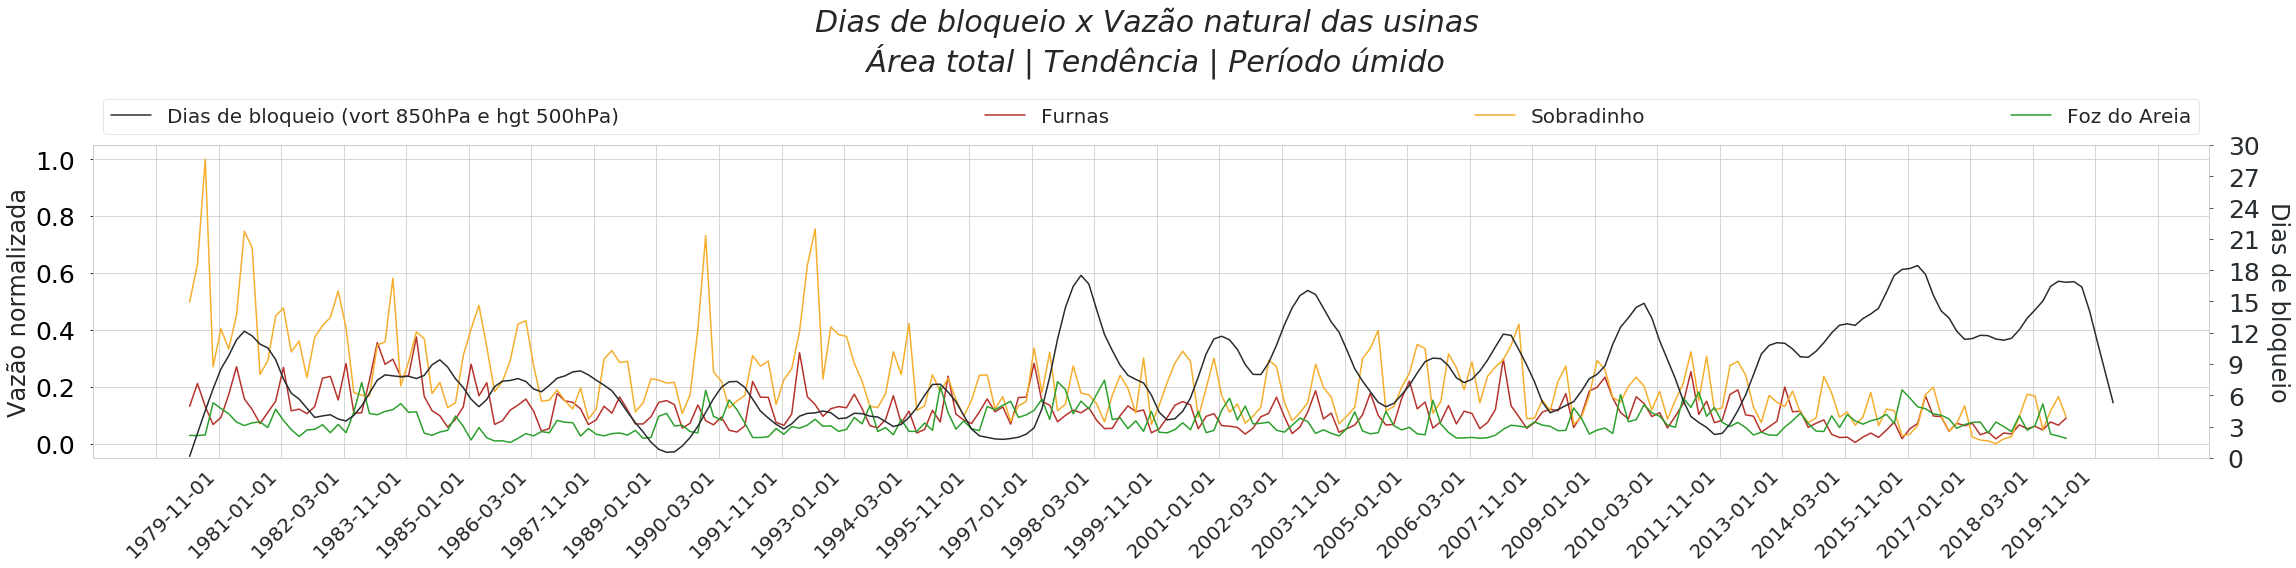

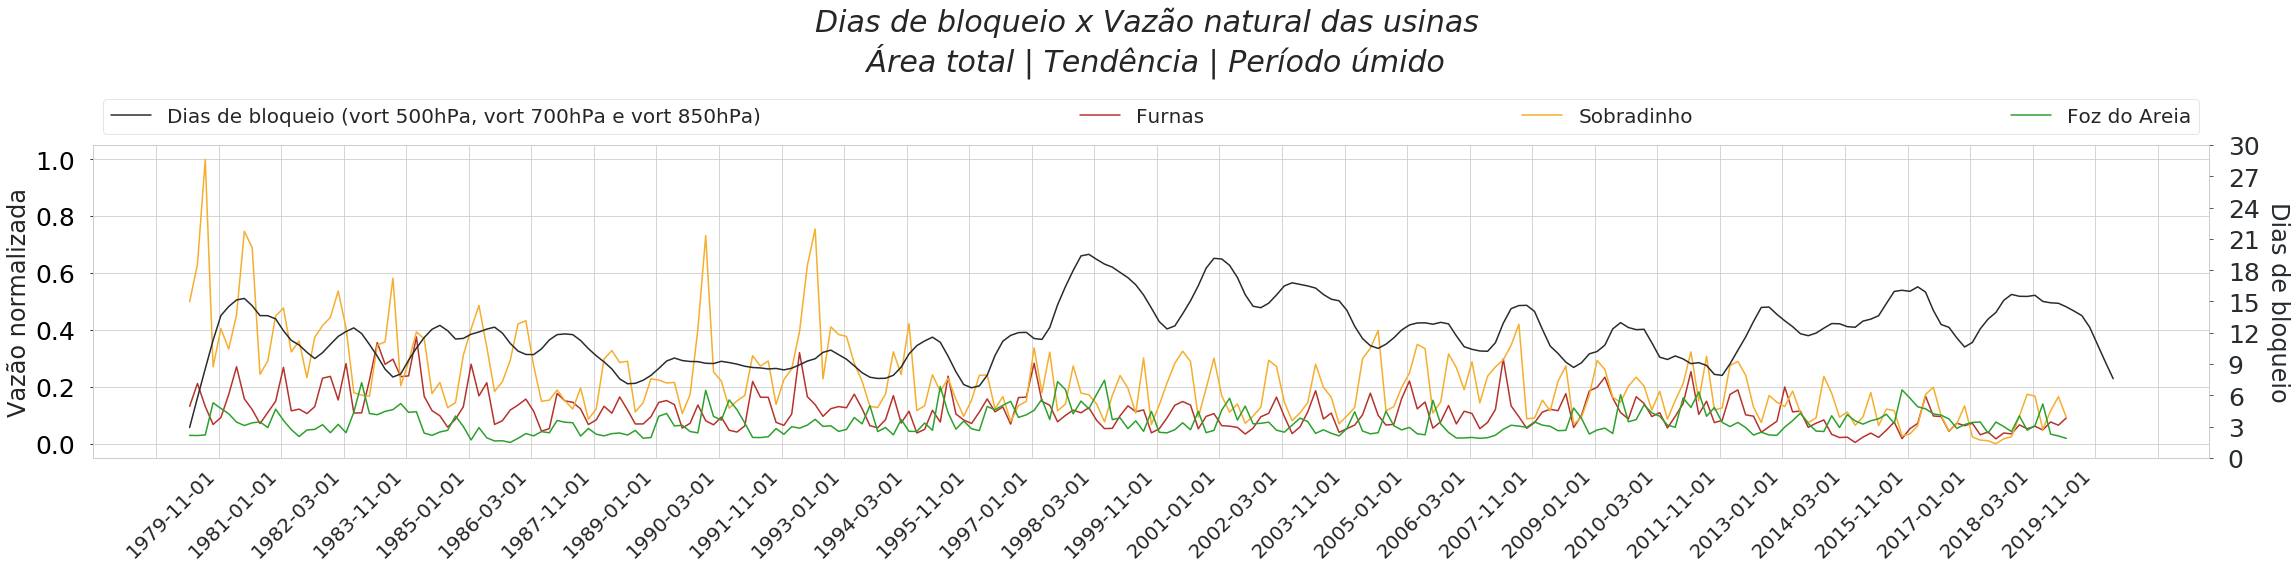

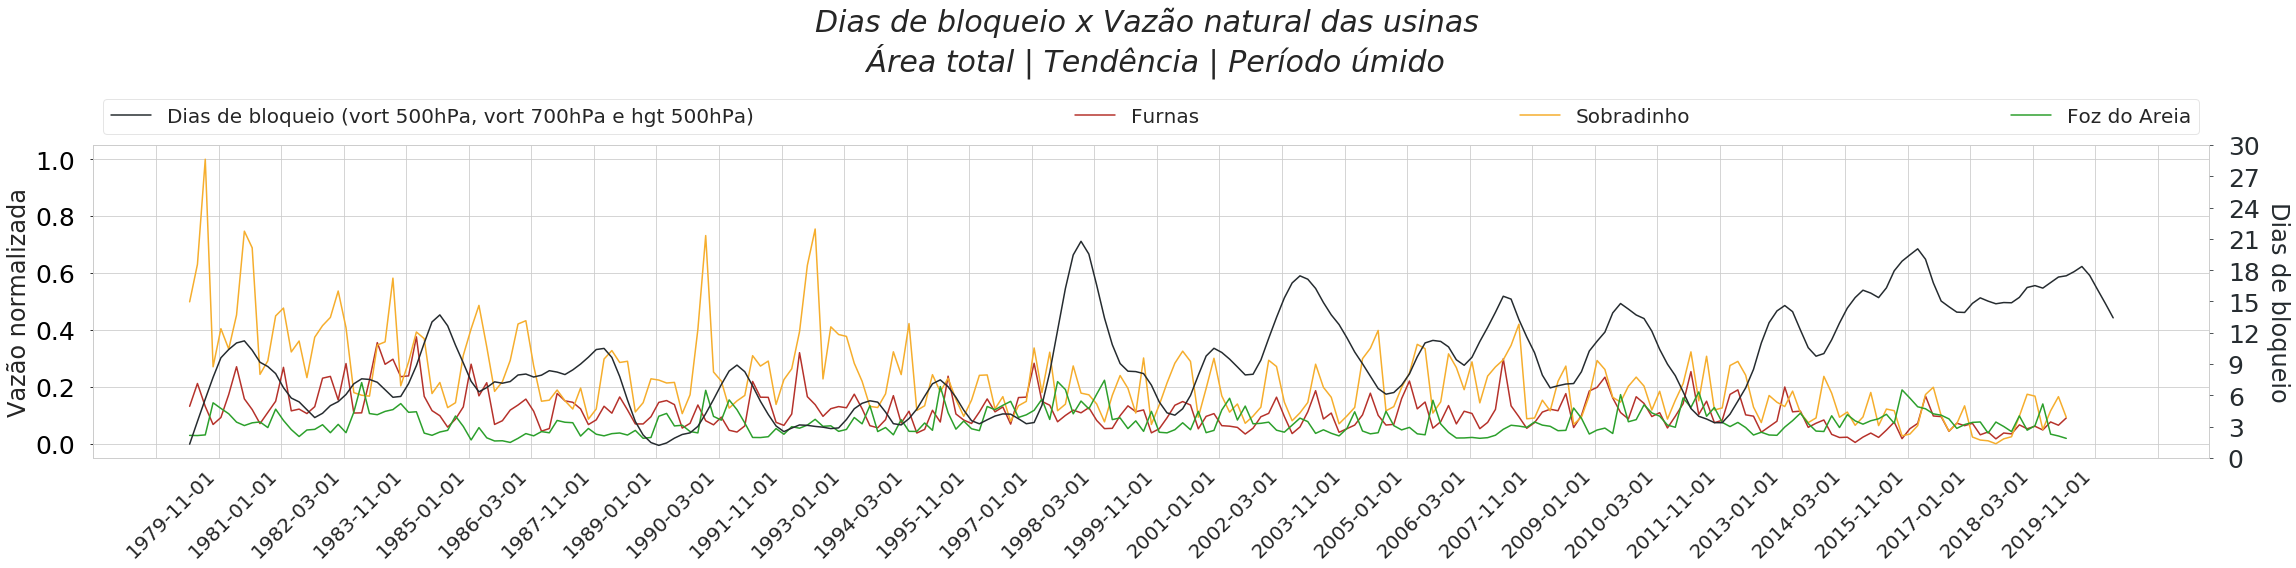

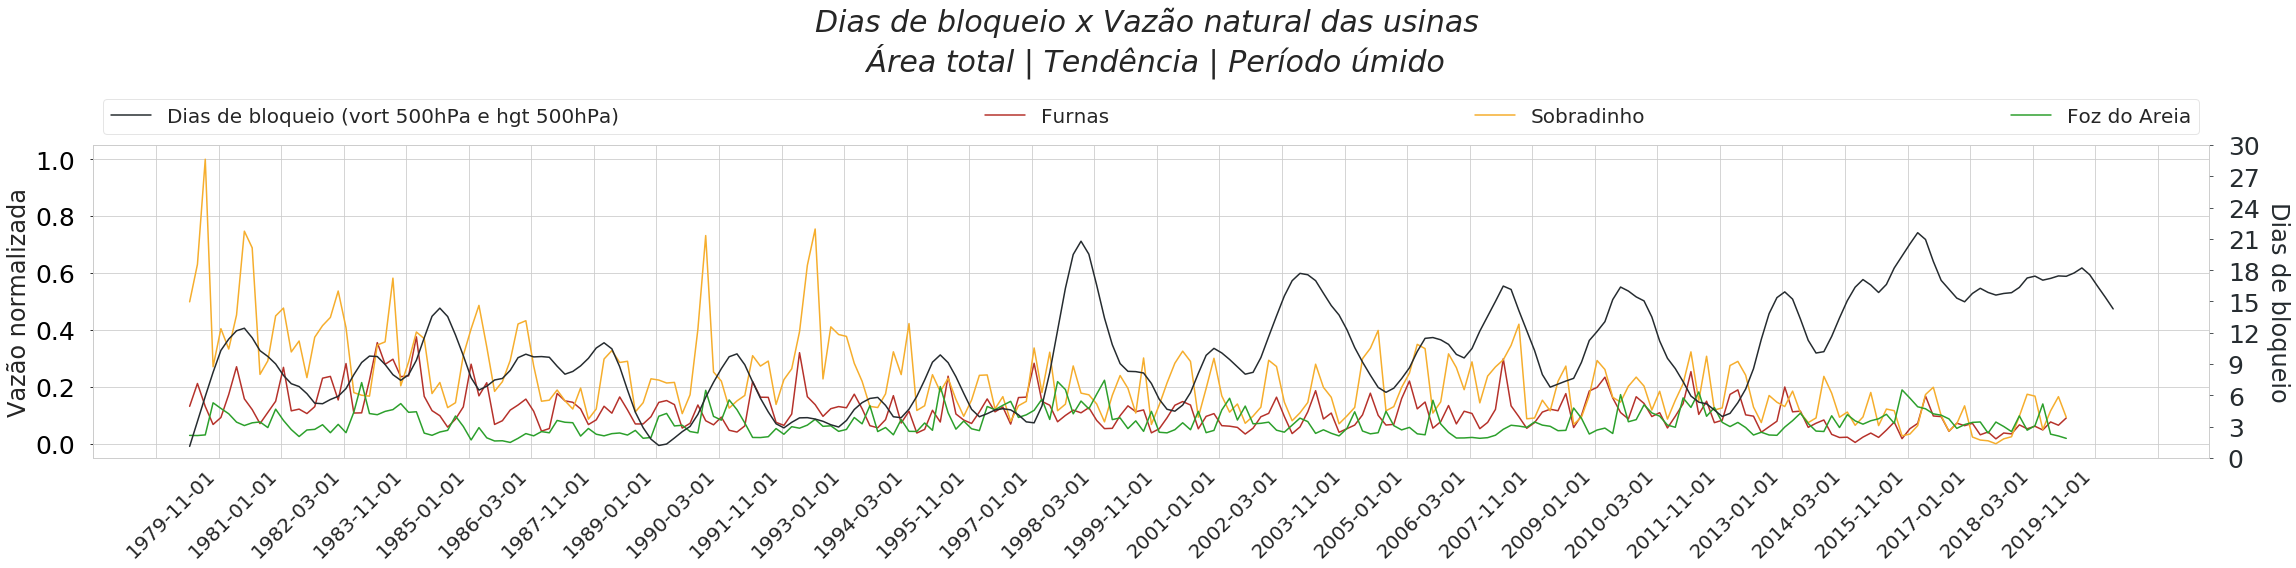

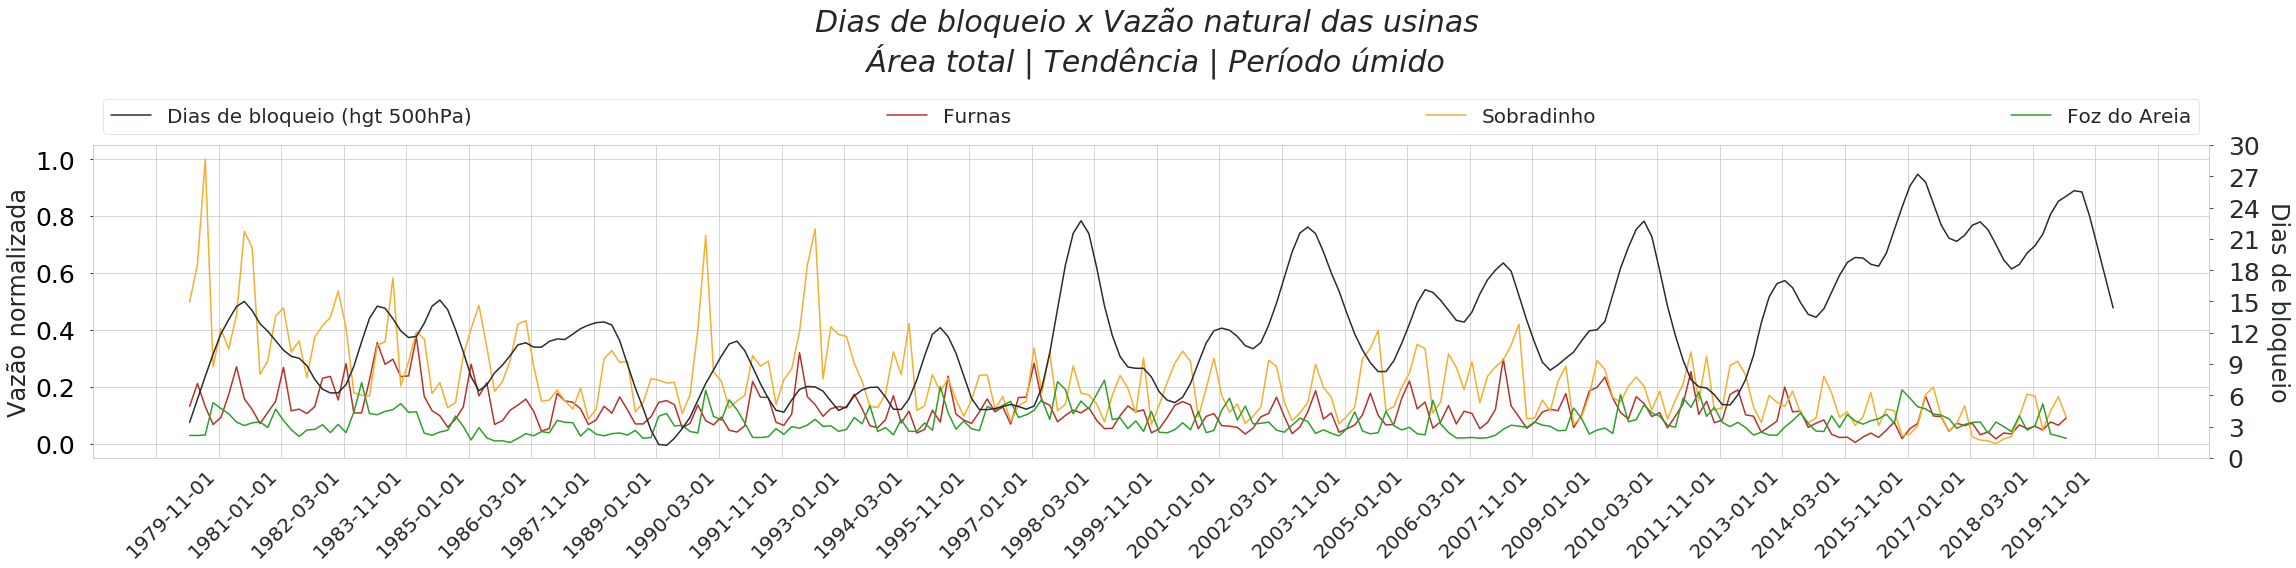

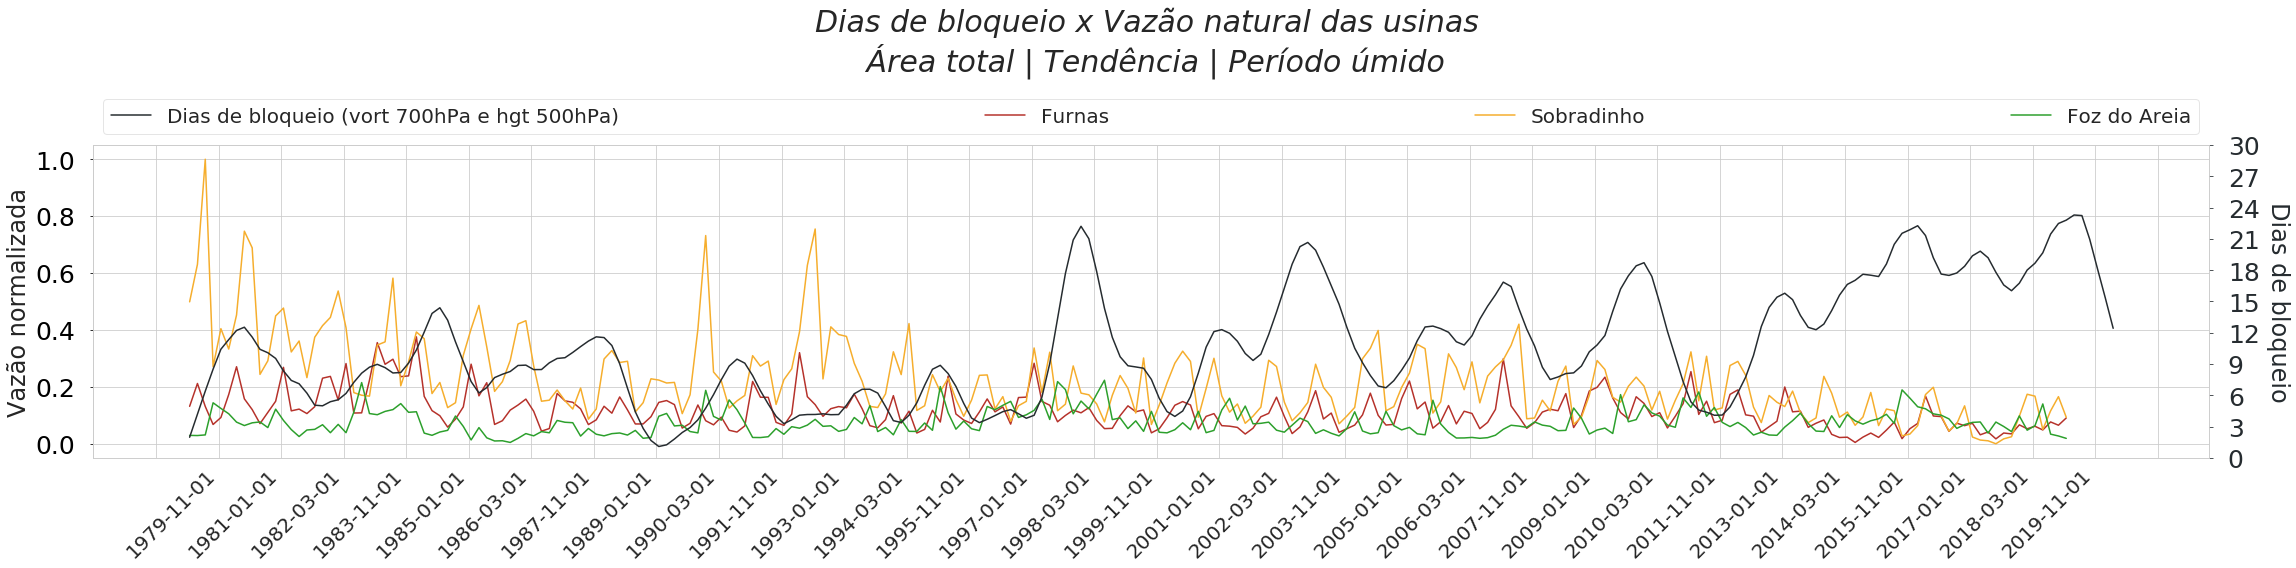

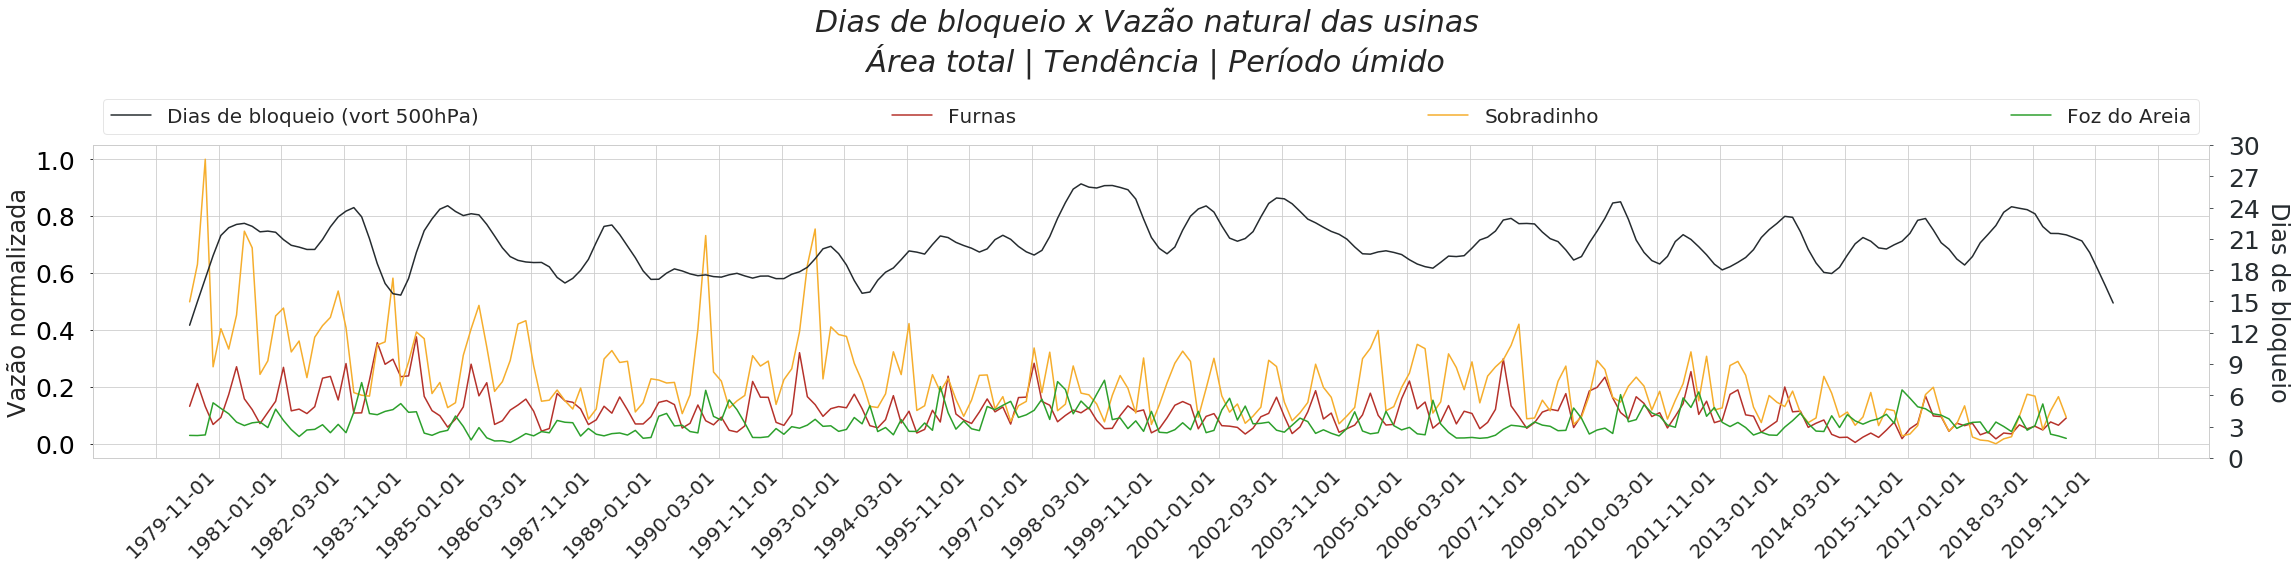

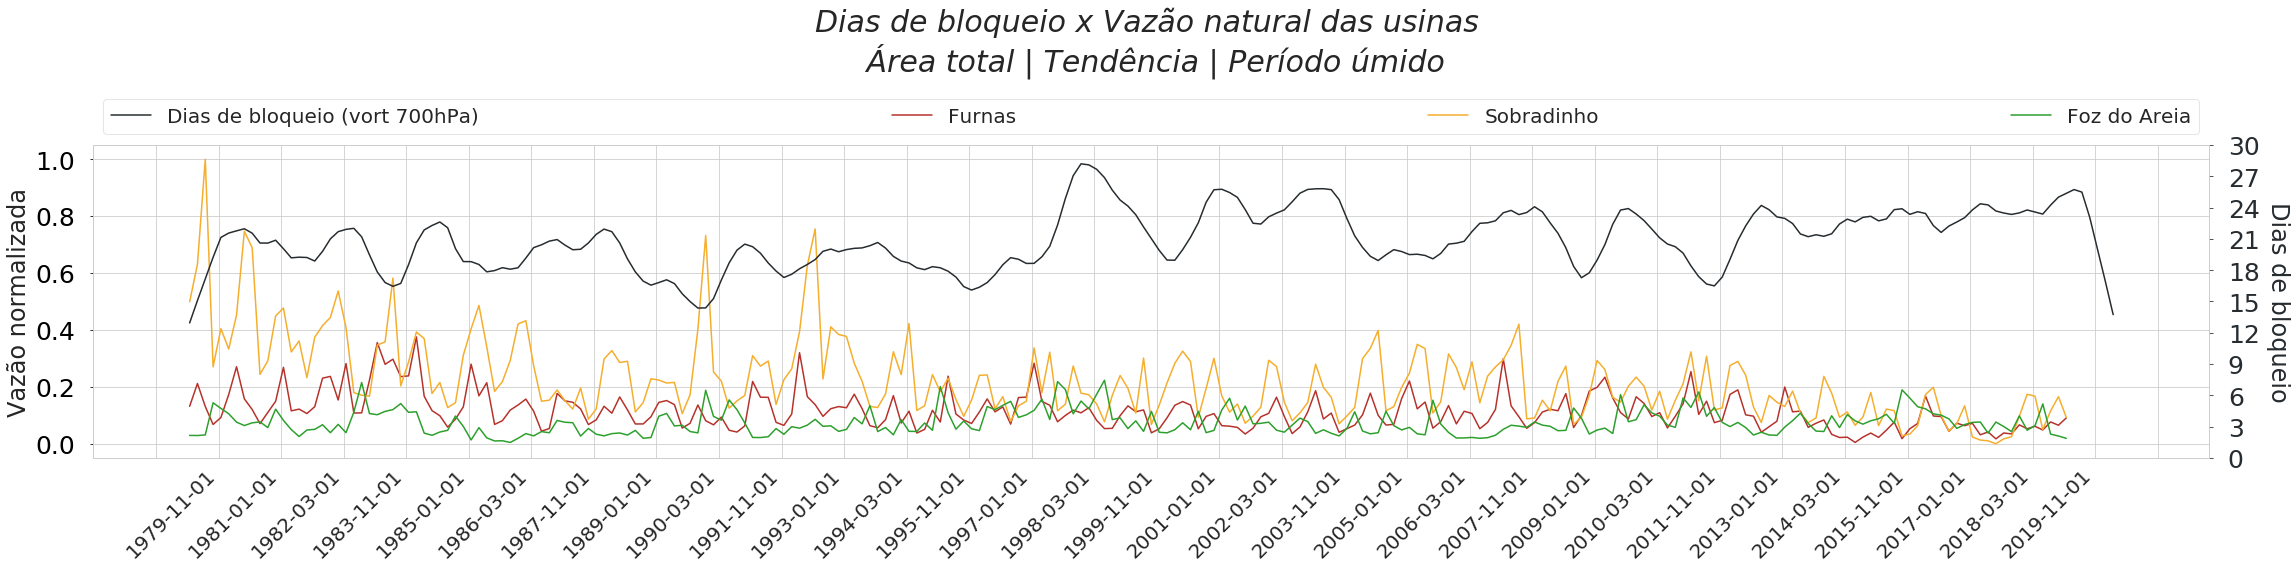

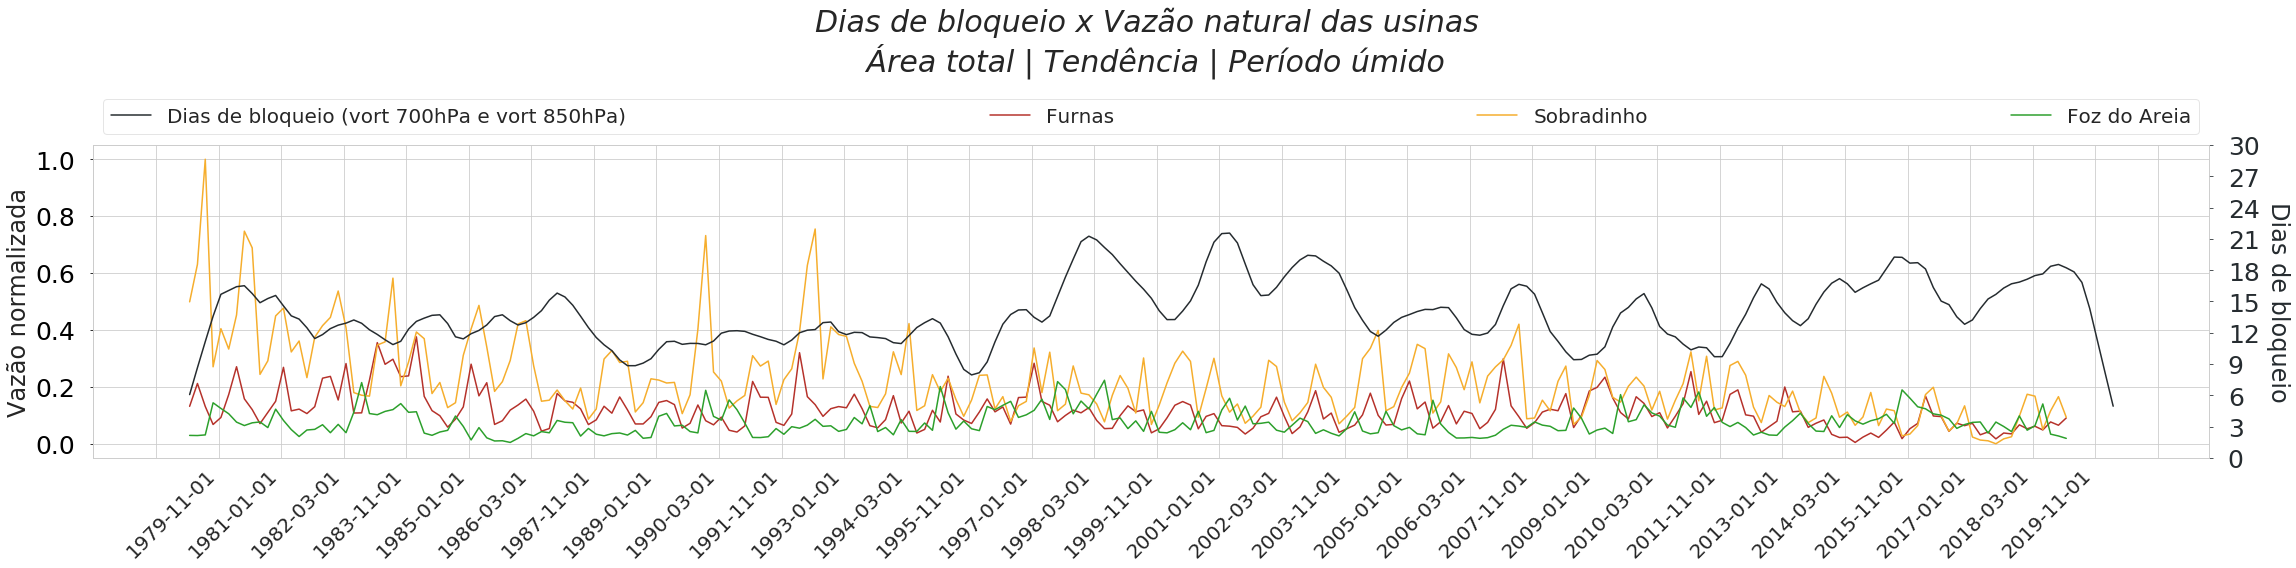

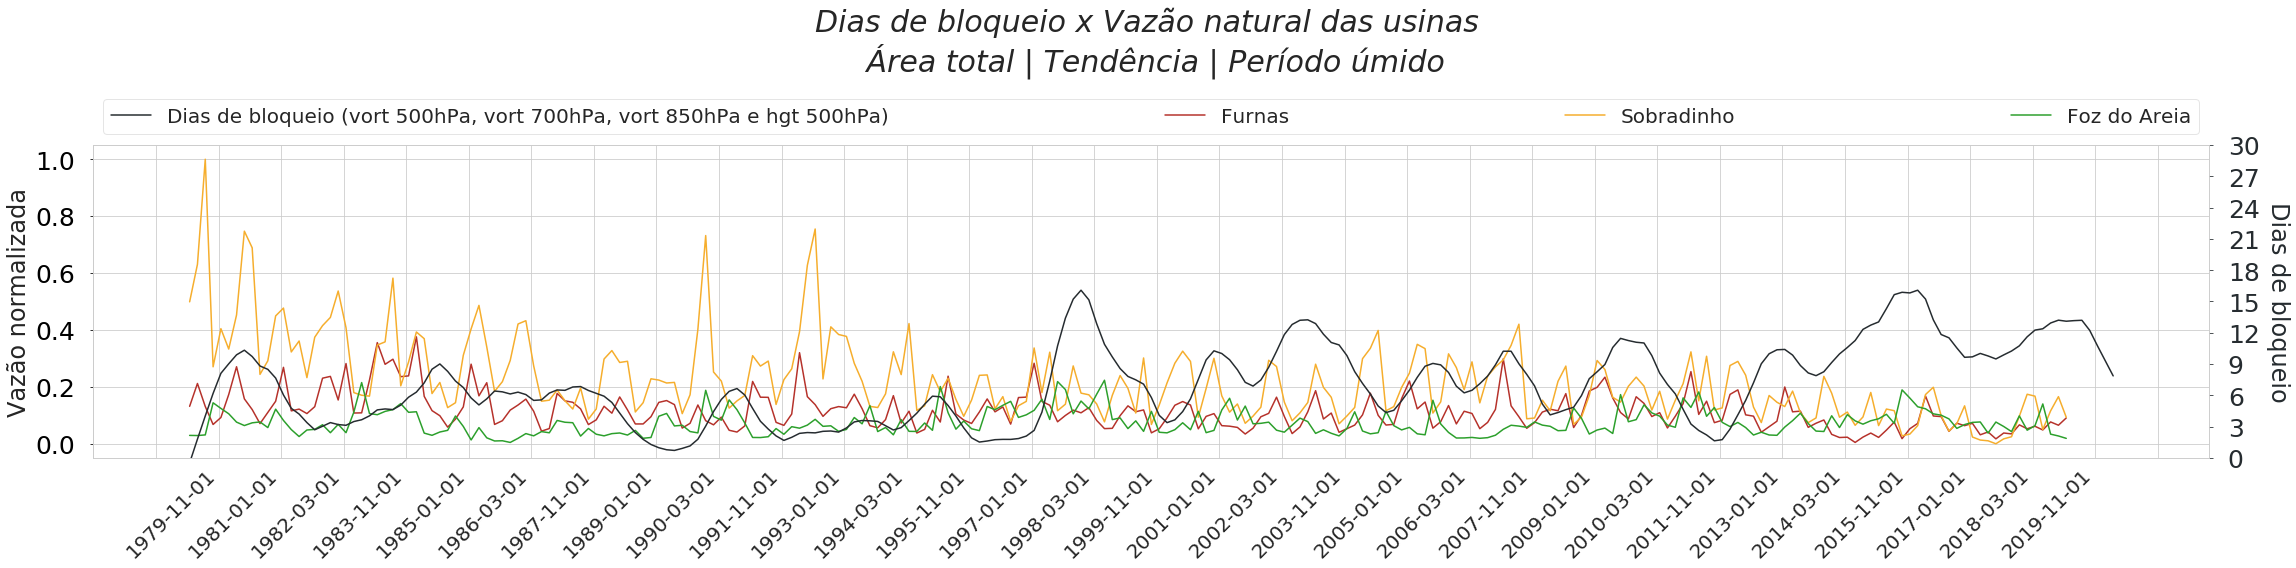

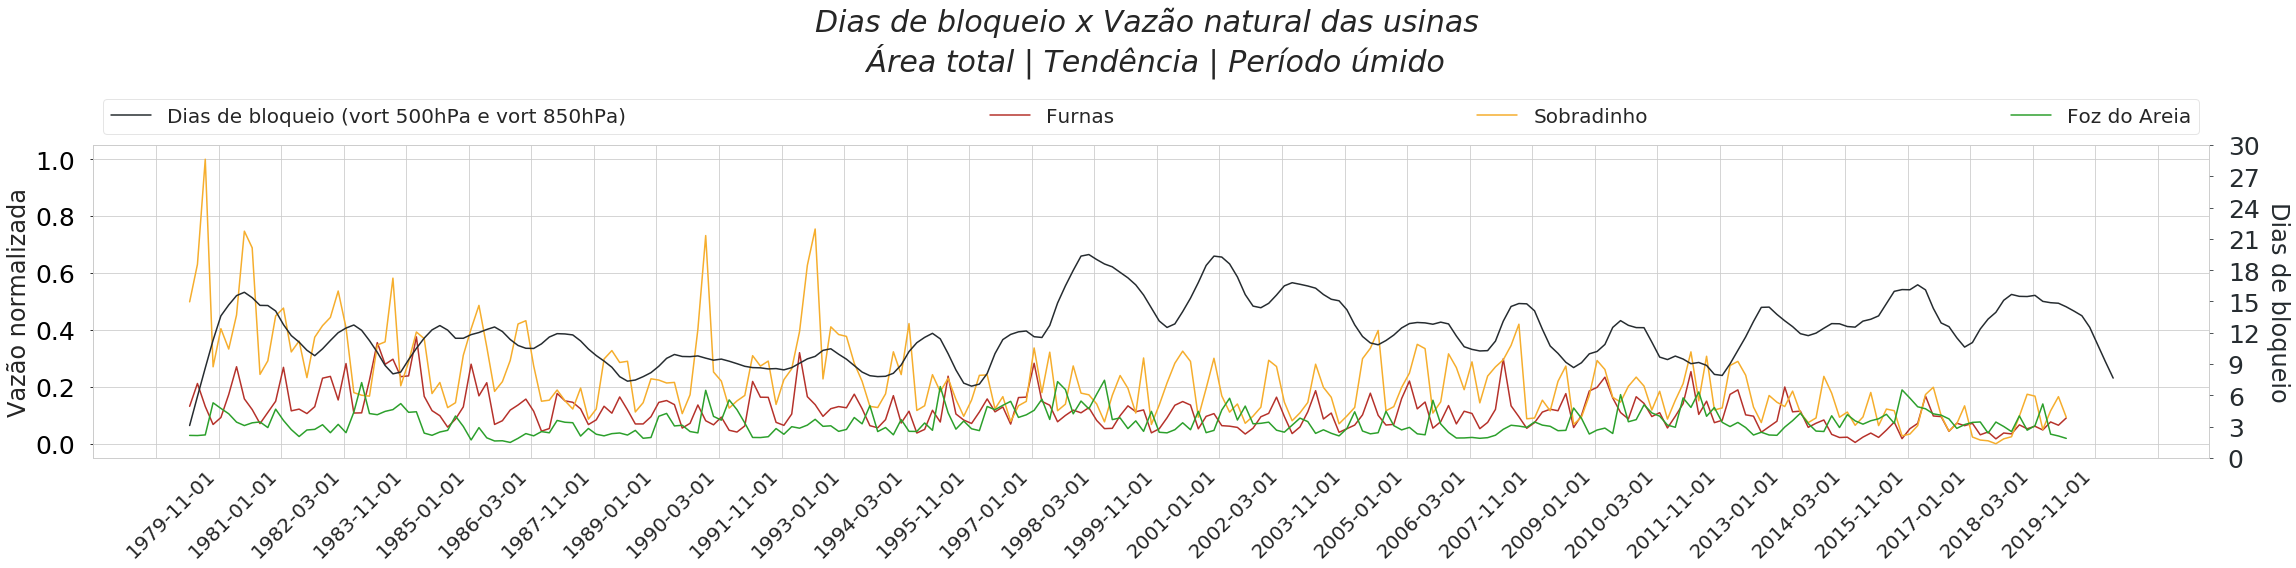

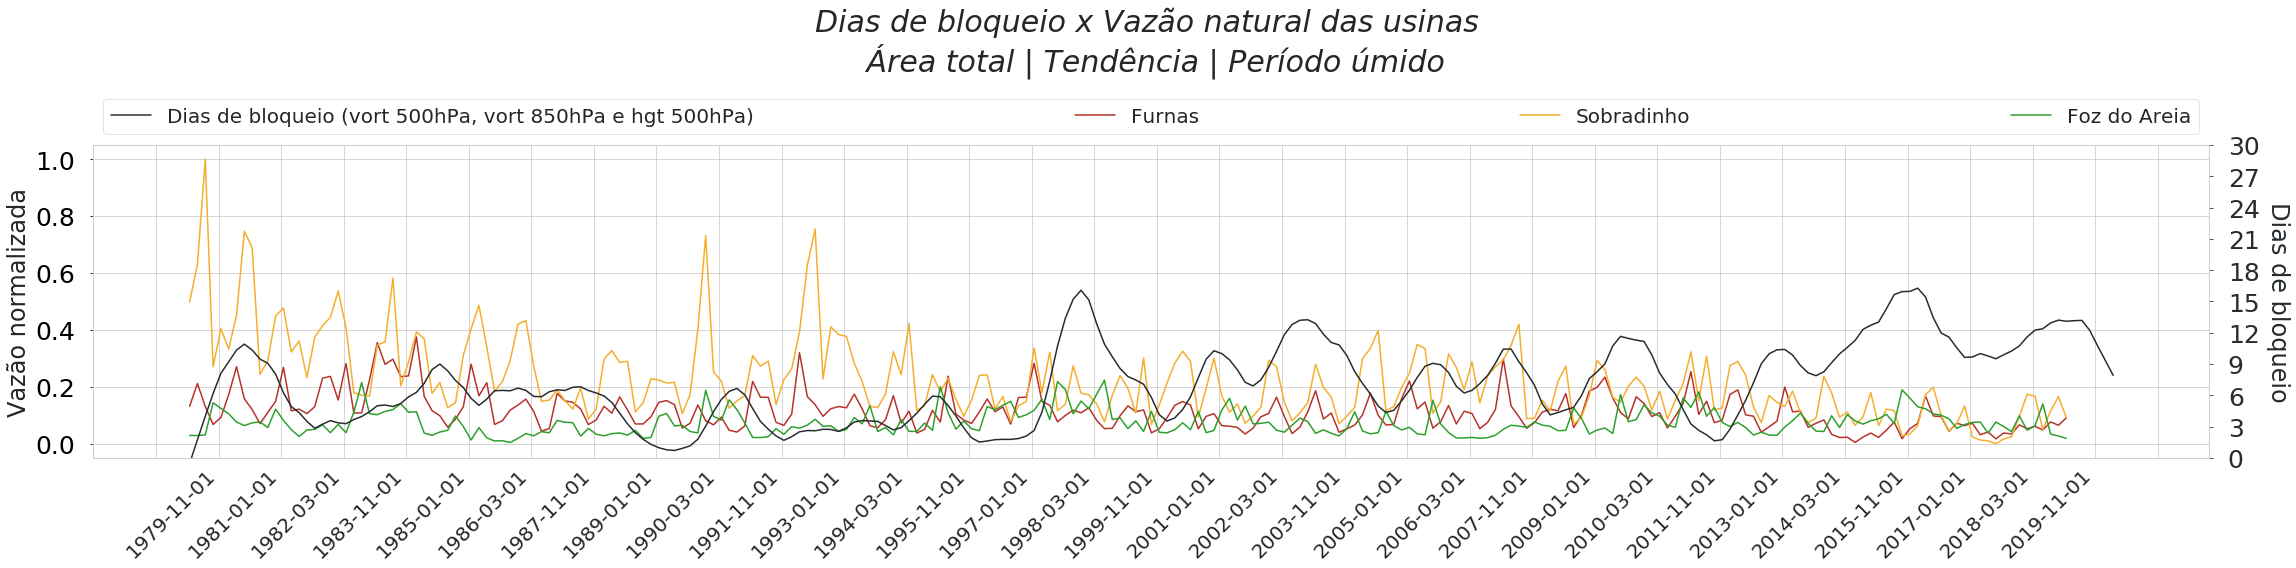

In [667]:
loess_vaz(usinas, tipos, series, savefig=True)

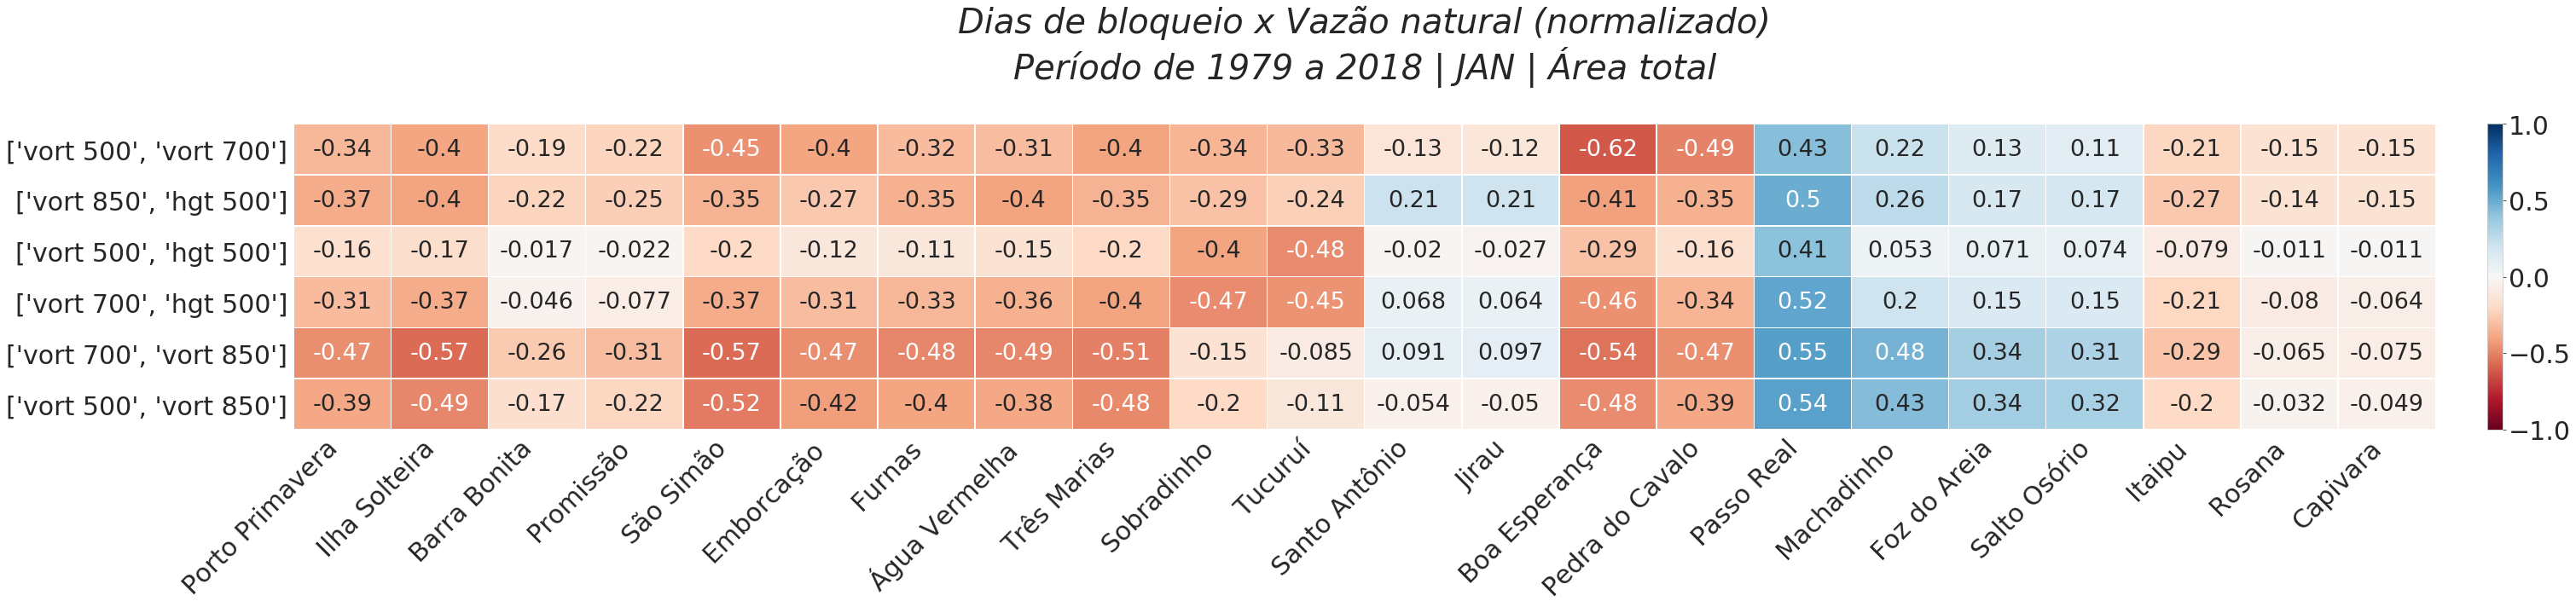

In [198]:
simplecorr(how=1, mes=1)

# Vazão

In [35]:
def dfvazoes(serie, usinas):
    #criando duas listas vazias para receber a vazão por usina e a vazão normalizada
    vaz_usina = []

    #O loop recebe o arquivo de vazões e dá o merge pra juntar o que for do sul com o resto do brasil.
    #depois disso, é atrelado a uma lista de vazões as usinas fornecidas pelo usuário, selecionadas
    #pelo código da usina. Depois de juntar todas as usinas solicitadas, dá o merge pra criar um dataset
    #apenas destas
    vazao_total = xr.merge(vazoes(regiao='todas'))

    for usina in usinas:
        vaz_usina.append(normalizar(vazao_total[usina].resample(time="MS").mean().to_dataset()))
    vazds = xr.merge(vaz_usina)
    

    #normalizando os valores das vazões, dado que algumas das usinas podem apresentar vazões muito
    #maiores umas das outras. Isso nivela os valores. Em seguida, é criado um dataframe com todos os valores
    #de vazão normalizados
    #normvaz = normalizar(vazds.resample(time="MS").mean())
    #df = normvaz.to_dataframe()
    df = vazds.to_dataframe()

    #recorte da série. caso serie = 'série histórica', o df permanece o mesmo, mas quando 
    #serie = 'período úmido', é necessário recortar o dataframe apenas para os meses entre
    #Outubro (10) e Março (3). Após o recorte, são calculadas as médias mensais e os valores 
    #NA são removidos do dataframe. O mesmo procedimento é feito caso o valor de serie seja uma
    #lista de meses (int)
    df = recorte(df, serie=serie)

    df.rename({'6': 'Furnas', '168': 'Sobradinho', '74': 'Foz do Areia'}, axis=1, inplace=True)

    return df

In [49]:
dfvazoes(serie='período úmido', usinas=['6', '168'])

Furnas  Sobradinho
time                            
1979-01-01  0.342002    0.498832
1979-02-01  0.558291    0.630731
1979-03-01  0.340529    1.000000
1979-10-01  0.169981    0.270475
1979-11-01  0.236271    0.404450
...              ...         ...
2018-03-01  0.153000    0.167327
2018-10-01  0.118133    0.050142
2018-11-01  0.193991    0.115708
2018-12-01  0.162871    0.165531
2019-01-01  0.231927    0.093131

[241 rows x 2 columns]

In [32]:
dfvazoes(serie='período úmido', usinas=['6'])

Furnas
time                
1979-01-01  0.342002
1979-02-01  0.558291
1979-03-01  0.340529
1979-10-01  0.169981
1979-11-01  0.236271
...              ...
2018-03-01  0.153000
2018-10-01  0.118133
2018-11-01  0.193991
2018-12-01  0.162871
2019-01-01  0.231927

[241 rows x 1 columns]

In [10]:
def vazoes(regiao = 'todas'):
    vazoes = pd.read_csv(os.path.join(os.getcwd(), "csv", "vazoesdiarias.csv"), sep=";", header=5, index_col=0, decimal = ',', low_memory=False)
    vazoes.index = pd.to_datetime(vazoes.index, errors='coerce')
    vazoes_br = vazoes.loc['1979-01-01' : '2019-01-01', ['246', '34', '237', '240', '33', '24', '6', '18', '156', '168', '275', '287', '285', '190', '254']]
    vazoes_br = vazoes_br.apply(pd.to_numeric, errors='ignore')
    vazoes_sul = vazoes.loc['1979-01-01' : '2019-01-01', ['111', '217', '74', '78', '66', '63', '61']]
    vazoes_sul = vazoes_sul.apply(pd.to_numeric, errors='ignore')
    br = xr.Dataset.from_dataframe(vazoes_br)
    br = br.rename({'index': 'time'})
    br = br.sortby('time')
    sul = xr.Dataset.from_dataframe(vazoes_sul)
    sul = sul.rename({'index': 'time'})
    sul = sul.sortby('time')
    if regiao == 'todas':
        return [br, sul]
    if regiao == 'sul':
        return sul
    if regiao == 'br':
        return br

In [5]:
def normalizar(ds):
    minimum = []
    maximum = []
    for index in ds.data_vars:
        minimum.append(ds.data_vars[index].values.min())
        maximum.append(ds.data_vars[index].values.max())
        datamin = np.min(minimum)
        datamax = np.max(maximum)
    norm = (ds-datamin)/(datamax-datamin)
    return norm

In [ ]:
vazcorrs(block, regiao='todas', freq='')

In [ ]:
def vazcorrs(atmds, regiao, freq, season=None, mes=None, savefig=False, save_csv=False, csv_type=None):
    
    '''
    Calcula as correlações entre os índices (bloqueio, vorticidade, divergência) e as vazões naturais das usinas.
    
    Os valores das vazões são normalizados para que, em razão da diferença entre as dimensões espaciais das usinas, não haja discrepância entre os dados. 
    
    Call signature.:
    
        vazcorrs(atmds, regiao, freq, season=None, mes=None, savefig=False, save_csv=False, csv_type=None)
    
    Parameters
    ----------
    
    atmds: list of <xarray.Dataset>
    
        Lista de datasets de vorticidade e divergência. 
        
        Função recebe até *três* datasets, sendo que o último da lista (atmds[2]), nesse estudo, deve ser o *dataset da vorticidade em 500 hpa*.
        
        EX.: atmds = [div850, vort850, vort500] --> vort500 por último (!!) --> div850 e vort850 não importa a ordem
    
    regiao: str, {"sul", "todas", "br"}
        
        Região das usinas em análise. 
        
            Se "sul", serão computadas somente usinas do sul do Brasil. 
        
            Se "br", todas as usinas *exceto* as do sul. 
        
            Se "todas", todas usinas serão computadas.
    
    freq: str, {"M" (ou 'month'), "season"}
    
        Determina o tipo de análise da série de dados. "Season" corresponde a análise sazonal e "M" (ou "month") mensal.
        
    season: str, {"DJF", "MAM", "JJA", "SON"}
        
        Estação do ano em análise. Somente se * freq == "season" *
      
    mes: int, range(1, 13)
    
        Mês do ano em análise. Somente se * freq == "M" *        
    
    Kwargs
    ------
    
    savefig: bool
        
        Salva a imagem gerada no diretório segundo o mesmo caminho em que 'arquivo.ipynb' está salvo e sendo executado. 
        
        O nome da imagem é pré-definido em função do tipo de bloqueio (Completo, Sul ou Norte), região (*regiao*), frequência (*freq*) e *season*/*mes* (depende do valor fornecido para *freq*) 

        Ex.: 'corr_VAZ_BloqueioNorte_SUL_DEC_1979_2010.png' --> nome da imagem equivalente ao Bloqueio Norte, usinas do sul, mês de dezembro e periodo de 1979 a 2010.
    
    save_csv: bool
    
        Salva o arquivo 'csv' do dataframe correspondente ao valor fornecido em *csv_type*.
        
        Assim como *savefig*, o nome do 'csv' é pré-definido em função do tipo de bloqueio (Completo, Sul ou Norte), região (*regiao*), frequência (*freq*) e *season*/*mes* (depende do valor fornecido para *freq*) 
 
        Ex.: 'corr_BloqueioNorte_SUL_DEC_1979_2010.csv' --> nome do 'csv' equivalente ao dataframe de correlações para Bloqueio Norte, usinas do sul, mês de dezembro e periodo de 1979 a 2010.

        
    csv_type: str, {"corr", "ind"}
    
        Determina o dataframe a ser exportado em formato 'csv'. 
        
            Se * csv_type == "corr" *, o 'arquivo.csv' exportado é aquele correspondente ao dataframe das correlações. 
        
            Se * csv_type == "ind" *, o 'arquivo.csv' exportado é aquele correspondente ao dataframe de índices antes de serem feitas as correlações. 
    
        Ex.: 'corr_VAZ_BloqueioNorte_SUL_DEC_1979_2010.csv' --> dataframe de correlações (*csv_type == 'corr'*)
        
        Ex.: 'df_VAZ_BloqueioNorte_SUL_DEC_1979_2010.csv' --> dataframe do índices sem correlações (*csv_type == 'ind'*)
    
    Returns
    -------
    
    Figure: <class 'matplotlib.figure.Figure'>
    
        Figura do gráfico de correlações entre os índices e as vazões naturais das usinas. 
    
    '''
    
    for ds in atmds:
        indice_bloq = ds
        print(ds)
        ext_name = ds.dataset.to_array().isel(variable=0)
        var = str(ext_name['variable'].values)
        ds = ds.rename({var: var + "_" + ds.level})
        print(ds)
        
        # DATASETS DOS ÍNDICES (DEPOIS SERÃO CONVERTIDOS EM DATASET)
    indice_bloq = blockix([atmds[0], atmds[1]], bloq='total', freq=freq)
    
    indice_div_vort = posix([atmds[0], atmds[1]], bloq='total', freq=freq)
    indice_div_vort = indice_div_vort.rename({"vort":"vort_850", "div":"div_850"})
    
    indice_vort_500 = posix(atmds[2], bloq='total', freq=freq)
    indice_vort_500 = indice_vort_500.rename({"vort":"vort_500"})
    
    indice_vort_700 = posix(atmds[3], bloq='total', freq=freq)
    indice_vort_700 = indice_vort_700.rename({"vort":"vort_700"})
    
    indice_div_700 = posix(atmds[4], bloq='total', freq=freq)
    indice_div_700 = indice_div_700.rename({"div":"div_700"})
    
    # NOMEANDO O BLOQUEIO EM FUNÇÃO DE SUAS LATITUDES (BLOQUEIO NORTE, SUL, COMPLETO)
    # 'BLOQ_NAME' PARA NOME DA IMAGEM SALVA E 'BLOQ_NAME_TITLE' PARA TITULO DA FIGURA
    if indice_div_vort.attrs['lat'][0:5] + '_' + indice_div_vort.attrs['lat'][8:13] == '-10.0_-25.0':
        bloq_name = "BloqueioCompleto"
        bloq_name_title = "Área total"
    if indice_div_vort.attrs['lat'][0:5] + '_' + indice_div_vort.attrs['lat'][8:13] == '-10.0_-17.5':
        bloq_name = "BloqueioNorte"
        bloq_name_title = "Setor norte"
    if indice_div_vort.attrs['lat'][0:5] + '_' + indice_div_vort.attrs['lat'][8:13] == '-17.5_-25.0':
        bloq_name = "BloqueioSul"   
        bloq_name_title = "Setor sul"
    print("BLOCK NOME")
    # FORMATANDO O DATASET DE VAZÕES PARA MESMO INTERVALO TEMPORAL DO DATASET DE INDICES_BLOQ / INDICES_DIV_VORT
    if regiao == "todas":
        vaz_br = vazoes(regiao=regiao)[0].sel(time=slice(pd.to_datetime(indice_bloq.time.values[0]), pd.to_datetime(indice_bloq.time.values[-1]))).to_array()
        vaz_sul = vazoes(regiao=regiao)[1].sel(time=slice(pd.to_datetime(indice_bloq.time.values[0]), pd.to_datetime(indice_bloq.time.values[-1]))).to_array()
        vaz_total = [vaz_br, vaz_sul]
        vaz = xr.concat(vaz_total, dim="variable").to_dataset(dim="variable")
    elif regiao == "sul":
        vaz = vazoes(regiao=regiao).sel(time=slice(pd.to_datetime(indice_bloq.time.values[0]), pd.to_datetime(indice_bloq.time.values[-1])))
        
    # FORMATANDO O DATASET DE VAZÕES PARA SER COERENTE COM O TIPO DE ANÁLISE DO DATASET DE ÍNDICES (DEPENDE DO VALOR DE 'FREQ')
    if freq == 'season':
        normvaz = normalizar(vaz.resample(time='QS-DEC').mean()).to_dataframe()
    elif freq == 'M' or freq == 'month':
        normvaz = normalizar(vaz.resample(time='MS').mean()).to_dataframe()
    
    # JUNTANDO OS 4 DATASETS E FORMATANDO EM DATAFRAME (TIRAR A CORRELAÇÃO E MELHOR VISUALIZAÇÃO)
    df = normvaz.join([indice_bloq.to_dataframe(), indice_div_vort.to_dataframe(), indice_vort_500.to_dataframe(), indice_vort_700.to_dataframe(), indice_div_700.to_dataframe()])
    df.fillna(0, inplace=True)
    print(df)
    # REORGANIZANDO AS COLUNAS DO DATAFRAME
    new = []
    col_list = list(df)
    for i in range(-4, 0):
        index = i
        new.append(col_list[index])
    for i in range(0, len(col_list)-4):
        new.append(col_list[i])
        
    df = df[new]
    df = df.rename(columns={"índice de bloqueios": "Dias de bloqueios", "div_850": "Persistência de divergência (850 hPa)", "vort_850": "Persistência de vorticidade (850 hPa)", "vort_500": "Persistência de vorticidade (500 hPa)", "246":"Porto Primavera", "34":"Ilha Solteira", "237":"Barra Bonita", "240":"Promissão", "33":"São Simão", "24":"Emborcação", "6":"Furnas", "18":"Água Vermelha", "156":"Três Marias", "168":"Sobradinho", "275":"Tucuruí", "287":"Santo Antônio", "285":"Jirau", "190":"Boa Esperança", "254":"Pedra do Cavalo", "111":"Passo Real", "217":"Machadinho", "74":"Foz do Areia", "78":"Salto Osório", "66":"Itaipu", "63":"Rosana", "61":"Capivara"})
    df = df.rename(columns={"vort_700": "Persistência de vorticidade (700 hPa)"})
    df = df.rename(columns={"div_700": "Persistência de divergência (700 hPa)"})
    print(df)
    # ADAPTANDO A ANÁLISE DA SÉRIE DE DADOS COM O VALOR FORNECIDO DE 'FREQ'
    if freq == 'season':
        if season == "DJF":
            df = df[df.index.month==12]         
        if season == "MAM":
            df = df[df.index.month==3]       
        if season == "JJA":
            df = df[df.index.month==6]                
        if season == "SON":
            df = df[df.index.month==9]
    elif freq == 'month' or freq == 'M':
        df = df[df.index.month==mes]
    
    # DICIONÁRIOS QUE SERÃO CONVERTIDOS PARA DATAFRAME APÓS CÁLCULO DE CORRELAÇÕES
    ixcorrs = {}
    v850corrs = {}
    d850corrs = {}
    v500corrs = {}
    v700corrs = {}
    d700corrs = {}
        
    # CÁLCULO DAS CORRELAÇÕES COM O TESTE DE SIGNIFÂNCIA (95 %)
    for column in df.columns:
        if stats.pearsonr(df[column], df['Dias de bloqueios'])[1] < 0.05:
            ixcorrs.update({column: stats.pearsonr(df[column], df['Dias de bloqueios'])[0]})
        else:
            ixcorrs.update({column: stats.pearsonr(df[column], df['Dias de bloqueios'])[0]})
        if stats.pearsonr(df[column], df['Persistência de vorticidade (850 hPa)'])[1] < 0.05:
            v850corrs.update({column: stats.pearsonr(df[column], df['Persistência de vorticidade (850 hPa)'])[0]})
        else:
            v850corrs.update({column: stats.pearsonr(df[column], df['Persistência de vorticidade (850 hPa)'])[0]})
        if stats.pearsonr(df[column], df['Persistência de divergência (850 hPa)'])[1] < 0.05:
            d850corrs.update({column: stats.pearsonr(df[column], df['Persistência de divergência (850 hPa)'])[0]})
        else:
            d850corrs.update({column: stats.pearsonr(df[column], df['Persistência de divergência (850 hPa)'])[0]})
        if stats.pearsonr(df[column], df['Persistência de vorticidade (500 hPa)'])[1] < 0.05:
            v500corrs.update({column: stats.pearsonr(df[column], df['Persistência de vorticidade (500 hPa)'])[0]})
        else:
            v500corrs.update({column: stats.pearsonr(df[column], df['Persistência de vorticidade (500 hPa)'])[0]})
        if stats.pearsonr(df[column], df['Persistência de vorticidade (700 hPa)'])[1] < 0.05:
            v700corrs.update({column: stats.pearsonr(df[column], df['Persistência de vorticidade (700 hPa)'])[0]})
        else:
            v700corrs.update({column: stats.pearsonr(df[column], df['Persistência de vorticidade (700 hPa)'])[0]})
        if stats.pearsonr(df[column], df['Persistência de divergência (700 hPa)'])[1] < 0.05:
            d700corrs.update({column: stats.pearsonr(df[column], df['Persistência de divergência (700 hPa)'])[0]})
        else:
            d700corrs.update({column: stats.pearsonr(df[column], df['Persistência de divergência (700 hPa)'])[0]})

            
    # CONVERTENDO PARA DATAFRAME AS CORRELAÇÕES CALCULADAS COM O TESTE DE SIGNIFICÂNCIA
    df_1 = pd.DataFrame.from_dict(ixcorrs, orient='index', columns=['Dias de bloqueios'])
    df_2 = pd.DataFrame.from_dict(v850corrs, orient='index', columns=['Persistência de vorticidade (850 hPa)'])
    df_3 = pd.DataFrame.from_dict(d850corrs, orient='index', columns = ['Persistência de divergência (850 hPa)'])
    df_4 = pd.DataFrame.from_dict(v500corrs, orient='index', columns = ['Persistência de vorticidade (500 hPa)'])
    df_5 = pd.DataFrame.from_dict(v700corrs, orient='index', columns = ['Persistência de vorticidade (700 hPa)'])
    df_6 = pd.DataFrame.from_dict(d700corrs, orient='index', columns = ['Persistência de divergência (700 hPa)'])

    # GERANDO E FORMATANDO O DATAFRAME FINAL DE CORRELAÇÕES
    df = pd.concat([df_1, df_3, df_2, df_4, df_5, df_6], axis=1)
    corre = df.T.drop(['Dias de bloqueios', 'Persistência de vorticidade (850 hPa)', 'Persistência de divergência (850 hPa)', 'Persistência de vorticidade (500 hPa)', 'Persistência de vorticidade (700 hPa)', 'Persistência de divergência (700 hPa)'], axis=1)
        
    # PLOTANDO O HEATMAP E ATRIBUINDO AS FORMATAÇÕES E 'DESIGN' NECESSÁRIOS PARA CADA REGIÃO
    if regiao == 'sul':
        corr, ax = plt.subplots(figsize=(12,5))
        corr = sns.heatmap(corre, annot=True, annot_kws={'fontsize':12, 'weight': 'bold'}, cbar_kws={'pad': 0.02}, cmap='RdBu', vmin=-1, vmax=1, center = 0, linewidths=0.5)
        plt.yticks(rotation=0, fontsize=12)
        plt.xticks(rotation=45, fontsize=12, ha="right")
        
    elif regiao == 'todas':
        corr, ax = plt.subplots(figsize=(47,10))
        corr = sns.heatmap(corre, annot=True, annot_kws={'fontsize':25, 'weight': 'bold'}, cbar=False, cmap="RdBu", linewidths=0.5, vmin=-1, vmax=1, center = 0)
        cbar = plt.colorbar(plt.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=-1.,vmax=1.), cmap="RdBu"), pad=0.02, orientation="vertical", ax=ax)
        cbar.ax.tick_params(labelsize=25)
        plt.xticks(rotation=45, fontsize=25, ha="right")
        plt.yticks(rotation=0, fontsize=25)
        
    # ESPECIFICAÇÕES DE TÍTULO DA FIGURA
    # PRÉ-DEFININDO OS NOMES DOS CSVs E IMAGENS A SEREM EXPORTADOS
    if freq == 'season':
        if regiao == 'sul':
            ax.set_title(bloq_name_title + ' x Usinas (' + regiao.upper() + ') | ' + str(pd.to_datetime(atmds[0].dataset.time.values[0]))[:4] + ' - ' + str(pd.to_datetime(atmds[0].dataset.time.values[-1]))[:4] + ' | ' + season + "\n\n\u03B1 = 0.05\n", fontsize=15, style="oblique")
        else:
            ax.set_title(bloq_name_title + ' x Usinas (' + regiao.upper() + ') | ' + str(pd.to_datetime(atmds[0].dataset.time.values[0]))[:4] + ' - ' + str(pd.to_datetime(atmds[0].dataset.time.values[-1]))[:4] + ' | ' + season + "\n\n\u03B1 = 0.05\n", fontsize=37, style="oblique")
        if savefig == True:
            plt.savefig('corr_VAZ_' + bloq_name + '_' + regiao.upper() + '_' + season + '_' + str(pd.to_datetime(atmds[0].dataset.time.values[0]))[:4] + '_' + str(pd.to_datetime(atmds[0].dataset.time.values[-1]))[:4] + '.png', format='png', dpi=200, bbox_inches="tight")
        if save_csv == True:
            if csv_type == "corr":
                corre.to_csv('corr_VAZ_' + bloq_name + '_' + regiao.upper() + '_' + season + '_' + str(pd.to_datetime(atmds[0].dataset.time.values[0]))[:4] + '_' + str(pd.to_datetime(atmds[0].dataset.time.values[-1]))[:4] + '.csv')
            elif csv_type == "ind":
                df.to_csv('df_VAZ_' + bloq_name + '_' + regiao.upper() + '_' + season + '_' + str(pd.to_datetime(atmds[0].dataset.time.values[0]))[:4] + '_' + str(pd.to_datetime(atmds[0].dataset.time.values[-1]))[:4] + '.csv')

    elif freq == 'month' or freq == 'M':
        if regiao == "sul":
            ax.set_title('Dias de bloqueio x Usinas | \u03B1 = 0.05 | ' + bloq_name_title + ' | ' + str(pd.to_datetime(atmds[0].dataset.time.values[0]))[:4] + ' - ' + str(pd.to_datetime(atmds[0].dataset.time.values[-1]))[:4] + ' | ' + calendar.month_abbr[mes].upper() + '\n', fontsize=15, style="oblique", pad=0.1)
        else:
            ax.set_title('Dias de bloqueio x Usinas | \u03B1 = 0.05 | ' + bloq_name_title + ' | ' + str(pd.to_datetime(atmds[0].dataset.time.values[0]))[:4] + ' - ' + str(pd.to_datetime(atmds[0].dataset.time.values[-1]))[:4] + ' | ' + calendar.month_abbr[mes].upper() + '\n', fontsize=37, style="oblique")

        if savefig == True:
            plt.savefig('corr_VAZ_' + bloq_name + '_' + regiao.upper() + '_' + calendar.month_abbr[mes].upper() + '_' + str(pd.to_datetime(atmds[0].dataset.time.values[0]))[:4] + '_' + str(pd.to_datetime(atmds[0].dataset.time.values[-1]))[:4] + '.png', format='png', dpi=200, bbox_inches="tight", transparent=True)
        if save_csv == True:   
            if csv_type == "corr":
                corre.to_csv('corr_VAZ_' + bloq_name + '_' + regiao.upper() + '_' + calendar.month_abbr[mes].upper() + '_' + str(pd.to_datetime(atmds[0].dataset.time.values[0]))[:4] + '_' + str(pd.to_datetime(atmds[0].dataset.time.values[-1]))[:4] + '.csv')
            elif csv_type == "ind":
                df.to_csv('df_VAZ_' + bloq_name + '_' + regiao.upper() + '_' + calendar.month_abbr[mes].upper() + '_' + str(pd.to_datetime(atmds[0].dataset.time.values[0]))[:4] + '_' + str(pd.to_datetime(atmds[0].dataset.time.values[-1]))[:4] + '.csv')


In [ ]:
seasons = ['DJF']
meses = [1, 12]#, "J", "F"]
regioes = ['todas']
periodos = [['1979-01-01', '2010-12-01'], ['2010-01-01', '2018-12-01']]
latitudes = [[-10, -25], [-17.5, -25], [-10,-17.5]]
for periodo in periodos:
    for latitude in latitudes:
        div_850 = uwnd_850.formatar(data_2=vwnd_850, lat = latitude, lon = [300, 320], time = periodo, level=850, opr='divergência')
        print("div  850: OK")
        vort_850 = uwnd_850.formatar(data_2=vwnd_850, lat = latitude, lon = [300, 320], time = periodo, level=850, opr='vorticidade')
        print("vort  850: OK")
        vort_500 = uwnd_500.formatar(data_2=vwnd_500, lat = latitude, lon = [300, 320], time = periodo, level=500, opr='vorticidade')
        print("vort 500: OK")
        div_700 = u700.formatar(data_2=v700, lat = latitude, lon = [300, 320], time = periodo, level=700, opr='divergência')
        print("div  700: OK")
        vort_700 = u700.formatar(data_2=v700, lat = latitude, lon = [300, 320], time = periodo, level=700, opr='vorticidade')
        print("vort  850: OK")
        
        for regiao in regioes:
            for season in seasons:
                for mes in meses:
                    df = vazcorrs([vort_850, div_850, vort_500, vort_700, div_700], regiao, freq='M', season=None, mes=mes, savefig=True, save_csv=False, csv_type=None)
                    #df = vazcorrs(, regiao, season, freq='M', mes=mes, varix=vort_500, vazix=True)

# ZCAS

In [ ]:
def zcas(freq='D'):
    zcasexcel = pd.read_excel("zcas.xlsx", sep=";", header=1, index_col=0, decimal = ',')  
    zcas = pd.DataFrame(zcasexcel['SUDESTE'].values, index = zcasexcel.index, columns=['zcas'])
    zcas.replace('zcas', 1, inplace=True)
    if freq == 'M':
        zcas = zcas.resample('MS').sum()
    if freq == "season":
        zcas = zcas.resample("QS-DEC").sum()
    reczcas = pd.concat([zcas[zcas.index.month <= 4], zcas[zcas.index.month >= 10]]).sort_index()
    return reczcas

In [ ]:
def zcascorrs(atmds, freq, varix=None):
    ZCAS = zcas(freq=freq)
    indice = blockix([atmds[0], atmds[1]], bloq='total', freq=freq)
    indice_div_vort = posix([atmds[0], atmds[1]], bloq='total', freq=freq)

    if indice_div_vort.attrs['lat'][0:5] + '_' + indice_div_vort.attrs['lat'][8:13] == '-10.0_-25.0':
        bloq_name = "BloqueioCompleto"
        bloq_name_title = "Área total"
    if indice_div_vort.attrs['lat'][0:5] + '_' + indice_div_vort.attrs['lat'][8:13] == '-10.0_-17.5':
        bloq_name = "BloqueioNorte"
        bloq_name_title = "Setor Norte"
    if indice_div_vort.attrs['lat'][0:5] + '_' + indice_div_vort.attrs['lat'][8:13] == '-17.5_-25.0':
        bloq_name = "BloqueioSul"   
        bloq_name_title = "Setor Sul"
    
    df = ZCAS.join([indice.to_dataframe(), indice_div_vort.to_dataframe()]).dropna()

    if varix != None:
        df.rename(columns={"zcas": "ZCAS/ZCOU", "vort": "Persistência de vorticidade (850 hPa)", "div": "Persistência de divergência (850 hPa)"}, inplace=True)
        indice_var = posix([varix], bloq='total', freq=freq)
        df = pd.concat([df, indice_var.to_dataframe()], axis=1).sort_index()
        df.rename(columns={"vort": "Persistência de vorticidade (500 hPa)", "índice de bloqueios": "Dias de bloqueios" }, inplace=True)    
    df.dropna(inplace=True)
    
        # DICIONÁRIOS QUE SERÃO CONVERTIDOS PARA DATAFRAME APÓS CÁLCULO DE CORRELAÇÕES
    ixcorrs = {}
    v850corrs = {}
    d850corrs = {}
    v500corrs = {}
        
    # CÁLCULO DAS CORRELAÇÕES COM O TESTE DE SIGNIFÂNCIA (95 %)
    for column in df.columns:
        if stats.pearsonr(df[column], df['Dias de bloqueios'])[1] < 0.05:
            ixcorrs.update({column: stats.pearsonr(df[column], df['Dias de bloqueios'])[0]})
        else:
            ixcorrs.update({column: stats.pearsonr(df[column], df['Dias de bloqueios'])[0]})
        if stats.pearsonr(df[column], df['Persistência de vorticidade (850 hPa)'])[1] < 0.05:
            v850corrs.update({column: stats.pearsonr(df[column], df['Persistência de vorticidade (850 hPa)'])[0]})
        else:
            v850corrs.update({column: stats.pearsonr(df[column], df['Dias de bloqueios'])[0]})
        if stats.pearsonr(df[column], df['Persistência de divergência (850 hPa)'])[1] < 0.05:
            d850corrs.update({column: stats.pearsonr(df[column], df['Persistência de divergência (850 hPa)'])[0]})
        else:
            d850corrs.update({column: stats.pearsonr(df[column], df['Dias de bloqueios'])[0]})
        if stats.pearsonr(df[column], df['Persistência de vorticidade (500 hPa)'])[1] < 0.05:
            v500corrs.update({column: stats.pearsonr(df[column], df['Persistência de vorticidade (500 hPa)'])[0]})
        else:
            v500corrs.update({column: stats.pearsonr(df[column], df['Dias de bloqueios'])[0]})
            
    df_1 = pd.DataFrame.from_dict(ixcorrs, orient='index', columns=['Dias de bloqueios'])
    df_2 = pd.DataFrame.from_dict(v850corrs, orient='index', columns=['Persistência de vorticidade (850 hPa)'])
    df_3 = pd.DataFrame.from_dict(d850corrs, orient='index', columns = ['Persistência de divergência (850 hPa)'])
    df_4 = pd.DataFrame.from_dict(v500corrs, orient='index', columns = ['Persistência de vorticidade (500 hPa)'])

    # GERANDO E FORMATANDO O DATAFRAME FINAL DE CORRELAÇÕES
    df_concat = pd.concat([df_1, df_3, df_2, df_4], axis=1)
    corre = df_concat.T.drop(['Dias de bloqueios', 'Persistência de vorticidade (850 hPa)', 'Persistência de divergência (850 hPa)', 'Persistência de vorticidade (500 hPa)'], axis=1)
    fig, ax = plt.subplots(figsize=(10,10))
    ax = sns.heatmap(corre, annot=True, annot_kws={'fontsize':15, 'weight': 'bold'}, cbar=False, cmap="RdBu", linewidths=0.5, vmin=-1, vmax=1, center = 0)
    cbar = plt.colorbar(plt.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=-1.,vmax=1.), cmap="RdBu"), pad=0.02, orientation="vertical", ax=ax)
    cbar.ax.tick_params(labelsize=10)
    plt.xticks(rotation=0, fontsize=15, ha="center")
    plt.yticks(rotation=0, fontsize=15)
    ax.set_title(bloq_name_title + ' | ' + str(df.index[0])[:4] + ' - ' + str(df.index[-1])[:4] + "\n\n\u03B1 = 0.05\n", fontsize=20, style="oblique")
    fig.tight_layout()
    plt.savefig(os.path.join(os.getcwd(), 'comsig' + bloq_name_title + ' x ZCASZCOU_' + str(df.index[0])[:4] + ' - ' + str(df.index[-1])[:4] + '.png'), transparent = True, format='png')

            
    #return df.to_csv('corr' + indice_vort_div.attrs['lat'] + '-' + indice_vort_div.attrs['lon'] + '_ZCAS_' + str(df.index[0].year) + '-' + str(df.index[-1].year) + '.csv')

In [ ]:
periodos = [['1979-01-01', '2010-12-01'], ['2010-01-01', '2018-12-01']]
latitudes = [[-10, -25], [-17.5, -25], [-10,-17.5]]
for periodo in periodos:
    for latitude in latitudes:
        div_850 = uwnd_850.formatar(data_2=vwnd_850, lat = latitude, lon = [300, 320], time = periodo, level=850, opr='divergência')
        vort_850 = uwnd_850.formatar(data_2=vwnd_850, lat = latitude, lon = [300, 320], time = periodo, level=850, opr='vorticidade')
        vort_500 = uwnd_500.formatar(data_2=vwnd_500, lat = latitude, lon = [300, 320], time = periodo, level=500, opr='vorticidade')
        df = zcascorrs([vort_850, div_850], freq='M', varix=vort_500)
                    #df = vazcorrs(, regiao, season, freq='M', mes=mes, varix=vort_500, vazix=True)

# Exportação da série histórica de índice de bloqueio

In [ ]:
periodos = ['serie', 'úmido']
latitudes = [[-10, -25], [-10, -17.5], [-17.5, -25]]
for latitude in latitudes:
    div_850 = uwnd_850.formatar(data_2=vwnd_850, lat = latitude, lon = [300, 320], time = ["1979-01-01", "2018-12-31"], level=850, opr='divergência')
    vort_850 = uwnd_850.formatar(data_2=vwnd_850, lat = latitude, lon = [300, 320], time = ["1979-01-01", "2018-12-31"], level=850, opr='vorticidade')
    for periodo in periodos:
        csvix([vort_850, div_850], latitude, periodo)

In [ ]:
def csvix(atms, lat, periodo='serie'): #serie; umido
    indice = blockix([atms[0], atms[1]], bloq='total', freq='M')    
    dfix = indice.to_dataframe()
    if periodo == 'umido' or periodo == 'úmido':
        ixoutdez = dfix[dfix.index.month>=10]
        ixjanmar = dfix[dfix.index.month<4]
        df = pd.concat([ixjanmar, ixoutdez]).sort_index()
    elif periodo == 'serie' or periodo == 'série':
        df = dfix
    return df.to_csv("indice_bloqueios_" + periodo + '_' + str(latitude[0]) + "_" + str(latitude[1]) + ".csv")

## anomalia acumulada e médias móveis

In [ ]:
def anom_easyplot(anom_df, anom_df_cusum, latitude=None, longitude=None):
    
    if latitude == [-10, -25]:
        corfundo = '#1E7099'
    elif latitude == [-10, -17.5]:
        corfundo = '#2A9D8F'
    elif latitude == [-17.5, -25]:
        corfundo = '#0E0F19'
    fig, ax = plt.subplots(figsize=(20, 5))
    escala = 10**4
    anom, = ax.plot(anom_df*escala, label='Anomalia', color = '#D9D8D3')
    roll, = ax.plot(anom_df.rolling(36).mean()*escala, color = corfundo, label='Média móvel')
    #plot de nan não afeta o resultado do gráfico, apenas carrega o label que falta para o ax2
    ax.plot(np.nan, '-r', label = 'Anomalia acumulada')  
    
    ax2 = ax.twinx()
    cusum = ax2.plot(anom_df_cusum*escala, color="#DD403A", label = 'Anomalia acumulada')
    ax.legend(loc='upper left')
    
    ax.tick_params(axis='y', colors='black')
    ax2.tick_params(axis='y', colors='#DD403A')

    ax2.grid(None)
      
    if str(anom_df.columns[0]) == 'vort':
        ax.set_ylabel('Anomalia de vorticidade (x '+ '$10^{-4}$ $s^{-1}$' + ')', color='black', fontsize = 12)
        ax2.set_ylabel('Anomalia acumulada de vorticidade (x '+ '$10^{-4}$ $s^{-1}$' + ')', fontsize = 12, labelpad = 20, color="#DD403A", rotation=-90)
        if latitude == None:
            ax.set_title('Vorticidade em 850 hPa', fontsize=25, style="oblique")
            fig.tight_layout()
            fig.savefig('Anomalia de vorticidade em 850 hPa.png')
        elif latitude != None:
            ax.set_title('Vorticidade em 850 hPa | ' + str(abs(latitude[0])) + 'S a ' + str(abs(latitude[1])) + 'S', fontsize = 25, style="oblique" )
            fig.tight_layout()
            fig.savefig('Anomalia de vorticidade em 850 hPa| ' + str(abs(latitude[0])) + 'S a ' + str(abs(latitude[1])) + 'S.png')

    elif str(anom_df.columns[0]) == 'div':
        ax.set_ylabel('Anomalia de divergência (x '+ '$10^{-4}$ $s^{-1}$' + ')', color='black', fontsize = 12)
        ax2.set_ylabel('Anomalia acumulada de divergência (x '+ '$10^{-4}$ $s^{-1}$' + ')', fontsize = 12, labelpad = 20, color="#DD403A")
        if latitude == None:
            ax.set_title('Divergência em 850 hPa', fontsize=25, style="oblique")
            fig.tight_layout()
            fig.savefig('Anomalia de divergência em 850 hPa.png')
        elif latitude != None:
            ax.set_title('Divergência em 850 hPa | ' + str(abs(latitude[0])) + 'S a ' + str(abs(latitude[1])) + 'S', fontsize=25, style="oblique")
            fig.tight_layout()
            fig.savefig('Anomalia de divergência em 850 hPa | ' + str(abs(latitude[0])) + 'S a ' + str(abs(latitude[1])) + 'S.png')
    
                        
    return fig, ax

In [ ]:
def anom_ac(ds, periodo=['1979-01-01', '2018-12-01'], bd = "NCEP", plot=False):
    ds_format = ds.formatar(time=[periodo[0], periodo[1]])
    anom_ds = ds_format.dataset - ds_format.climatologia().dataset
    anom_ds = nb.dataset(anom_ds.to_netcdf(), "NCEP")
    med_anom_ds = anom_ds.formatar().media_regional()
    df_anom = med_anom_ds.dataset.to_dataframe()
    ac_df = np.cumsum(df_anom)
    latitude = [ds.dataset.lat[0].values.tolist(), ds.dataset.lat[-1].values.tolist()]
    longitude = [ds.dataset.lon[0].values.tolist(), ds.dataset.lon[-1].values.tolist()]
    print(latitude)
    if plot == True:
        anom_easyplot(df_anom, ac_df, latitude=latitude)